In [1]:
#ASE model

In [2]:
#only works with reference folders index 017 and up (Not 023)

In [3]:
#imports:

from ase import Atom
from ase import Atoms
from ase.io import read, write
from ase.build import surface, cut
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from ase.visualize import view
from ase.constraints import FixedLine

import pyace

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import csv
import os
import shutil
import subprocess
import re
import sys
import copy
from scipy.interpolate import griddata


In [4]:
#Safty copy of the ML_Potential: /nfshome/karanikv/TU-Darmstadt-Work/Training_Potentials/2025_03_03_ReFitting_8_embending_functions_gpunode2/potential_iteration_1559_new_kappa_0p05.yaml in nfshome/okresa/
path_to_pot = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ML_Potential"
potential_name = "potential_iteration_1559_new_kappa_0p05.yaml"

print(f'Path_to_potential: {path_to_pot}/{potential_name}')
pot = pyace.PyACECalculator(f'{path_to_pot}/{potential_name}')


Path_to_potential: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ML_Potential/potential_iteration_1559_new_kappa_0p05.yaml


In [5]:
#define functions:
def gb_energy(atoms, eref_Cu, eref_Ag, xAg=0):
    a, b = atoms.cell[0], atoms.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    Energy_uncorrect = atoms.get_potential_energy()
    e = Corrected_Energy(Energy_uncorrect,atoms)
    return (e - len(atoms) *((1 - xAg) * eref_Cu + xAg * eref_Ag)) / (2*A)


def gb_energy_averaged(atoms, eref_Cu, eref_Ag, xAg=0):
    a, b = atoms.cell[0], atoms.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    #set e_avr variable after avaraging script
    return (e_avr - len(atoms) *((1 - xAg) * eref_Cu + xAg * eref_Ag)) / (2*A)


#Energy was omitted to fit a graph and must be recorrected
def Corrected_Energy(Energy_uncorrect,atoms):
    Number_Atoms = list(atoms.symbols)
    Ag_number = Number_Atoms.count('Ag')
    Cu_number = Number_Atoms.count('Cu')
    Ga_number = Number_Atoms.count('Ga')
    Se_number = Number_Atoms.count('Se')
    
    E_Ag = -0.07060507
    E_Cu = -0.06457733
    E_Ga = -0.07974831
    E_Se = -0.16179301
    return Energy_uncorrect + Ag_number*E_Ag + Cu_number*E_Cu + Ga_number*E_Ga + Se_number*E_Se


def optimize(atoms, fmax=0.1, write=False, fname=None):
    # Constrain each atom individually along the z-direction
    indices1 = [atom.index for atom in atoms]
    #c = FixedLine(indices=indices, direction=[0, 0, 1])
    indices = list(range(len(atoms)))  # Ensure indices is a list of atom indices
    CC = []
    for index in indices:
        CC.append(FixedLine(index, [0, 0, 1]))
    atoms.set_constraint(CC)

    # Initialize and run the BFGS optimizer
    opt = BFGS(atoms)
    opt.run(fmax=fmax,steps=250)

    # Optionally write the optimized structure to a file
    if write:
        if fname:
            atoms.write("{}".format(fname), vasp5=True, direct=True, sort=True)
        else:
            atoms.write("opt.POSCAR", vasp5=True, direct=True, sort=True)

    return None


def optimize1(atoms, fmax=0.001, mask=(1, 1, 1, 0, 0, 0), write=False, fname=None):
    opt = BFGS(atoms)
    opt.run(fmax=fmax,steps=250)
    ucf = UnitCellFilter(atoms,constant_volume=True, mask=mask)
    #ucf = UnitCellFilter(atoms,constant_volume=False, mask=mask)
    opt = BFGS(ucf)
    opt.run(fmax=fmax,steps=250)
    if write:
        if fname:
            atoms.write("{}".format(fname), vasp5=True, direct=True, sort=True)
        else:
            atoms.write("opt.POSCAR", vasp5=True, direct=True, sort=True)

    return None


In [6]:
# 1. Find the center of the atoms object
def find_center_of_atoms(atoms):
    # The center is the mean of the positions
    center = np.mean(atoms.positions, axis=0)
    print(f"Center of the atoms: {center}")
    return center

# 2. Find the [Cu] atom closest to the center
def find_closest_atom_to_center(atoms, center, atom_type):
    """
    Finds the atom of type `atom_type` closest to the center of the atoms object.

    Parameters:
    - atoms: The ASE Atoms object.
    - center: The center coordinates of the atoms object.
    - atom_type: The type of atom to search for (e.g., 'Cu').

    Prints the index and coordinates of the closest atom of the specified type to the center.
    """
    # Extract the positions and symbols of the atoms
    positions = atoms.positions
    symbols = atoms.symbols

    # Find the indices of atoms that match the specified atom_type
    atom_indices = [i for i, symbol in enumerate(symbols) if symbol == atom_type]

    # If no atoms of the specified type are found, print a message and return
    if not atom_indices:
        print(f"No atoms of type {atom_type} found.")
        return

    # Calculate distances from the center to each atom of the specified type
    distances = [np.linalg.norm(pos - center) for i, pos in enumerate(positions) if i in atom_indices]

    # Find the index of the closest atom
    closest_atom_index = atom_indices[np.argmin(distances)]
    closest_atom_position = atoms.positions[closest_atom_index]

    print(f"Closest {atom_type} atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")
    return closest_atom_index, closest_atom_position


# 3. Swap the [Cu] atom closest to the center with Bi
def swap_atoms(atoms, atoms_to_swap, visually_destinct_element = "Bi"):
    """
    Swaps the selected atoms with new atoms of the visually distinct element.
    
    Parameters:
    - atoms: The list of atoms.
    - atoms_to_swap: List of atom indices to be swapped.
    - visually_destinct_element: The element to swap atoms with.
    
    Returns:
    - atoms: The modified atoms with the swapped atoms.
    """
    if isinstance(atoms_to_swap, int):
        print(f"The variable is an integer: {atoms_to_swap}")
        atoms[atoms_to_swap].symbol = visually_destinct_element
    elif isinstance(atoms_to_swap, list):
        print(f"The variable is a list: {atoms_to_swap}")
        for idx in sorted(atoms_to_swap, reverse=True):  # Iterate in reverse order to avoid index shifting
            # Replace the atom with a new one of the selected element (visually_distinct_element)
            print(f"Swapping atom at index {idx}: {atoms[idx]} with {visually_destinct_element}")
            atoms[idx].symbol = visually_destinct_element
    else:
        print("The variable is neither an integer nor a list.")

    return atoms

# Extra. Ask for a visulaisation of the GB
def ask_user_for_visuals(atoms, ask_to_check_visuals = "skip"):
    if ask_to_check_visuals != "skip":
        ask_to_check_visuals = input("Check with visualisation? y/N: ").strip().lower()
    if ask_to_check_visuals == 'y':
        #if y --> If possible manually fix it in ASE window 
        print("Script will continue after closing the ASE gui window.\nEdits will be saved\nplease correct the deletion layer using the Ctrl+Y feature in ASE")
        atoms.edit()
    else:
        print("Skipping visualistion.")

#5 get a line of bulk_base atoms to replace:
def get_atoms_with_larger_z(atoms, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.1):
    """
    Finds the indices of all atoms of type `bulk_base` (e.g., 'Cu') that have a larger z-coordinate
    than the atom at `closest_atom_position` and are within `y_tolerance` in the y-coordinate.
    
    Parameters:
    - atoms: List of atom objects, each with 'element' (atom type) and 'coordinates' (x, y, z).
    - bulk_base: The atom type to search for (default is 'Cu').
    - closest_atom_position: The index of the closest atom to compare against.
    - y_tolerance: The allowed tolerance in the y-coordinate to consider the atom as within range.
    
    Returns:
    - distance_to_center_index_list: A list of indices of atoms meeting the conditions.
    """
    # define distance_to_center_index_list 
    distance_to_center_index_list = [closest_atom_index]
    # Get the coordinates of the closest atom
    #closest_atom = atoms[closest_atom_index]
    closest_atom_x = closest_atom_position[0]
    closest_atom_y = closest_atom_position[1]
    closest_atom_z = closest_atom_position[2]
    print(f"TEST 1: closest_atom_position: {closest_atom_position}")
    print(f"TEST 1: x = {closest_atom_x}, y = {closest_atom_y}, z = {closest_atom_z} ")
    # Iterate through the atoms to find matching atoms
    for idx, atom in enumerate(atoms):
        #atom(symbol='X', position=(0, 0, 0), tag=None, momentum=None, mass=None, magmom=None, charge=None, atoms=None, index=None)
        atom_x = atom.position[0]
        atom_y = atom.position[1]
        atom_z = atom.position[2]
        
         # Check if the z-coordinate of a bulk_base is larger then the center and the y-coordinate is within tolerance
        if atom.symbol == bulk_base and atom_z > closest_atom_z and abs(atom_y - closest_atom_y) <= y_tolerance:
            print(f"TEST 2: x = {atom_x}, y = {atom_y}, z = {atom_z}")
            distance_to_center_index_list.append(idx)      
    
    return distance_to_center_index_list

In [7]:
#define NEW new new functions (section 8 and 9)

# 1. Find the center of the atoms object
def find_center_of_atoms(atoms):
    # The center is the mean of the positions
    center = np.mean(atoms.positions, axis=0)
    print(f"Center of the atoms: {center}")
    return center

# 2. Find the [Cu] atom closest to the center
def find_closest_atom_to_center(atoms, center, atom_type):
    """
    Finds the atom of type `atom_type` closest to the center of the atoms object.

    Parameters:
    - atoms: The ASE Atoms object.
    - center: The center coordinates of the atoms object.
    - atom_type: The type of atom to search for (e.g., 'Cu').

    Prints the index and coordinates of the closest atom of the specified type to the center.
    """
    # Extract the positions and symbols of the atoms
    positions = atoms.positions
    symbols = atoms.symbols

    # Find the indices of atoms that match the specified atom_type
    atom_indices = [i for i, symbol in enumerate(symbols) if symbol == atom_type]

    # If no atoms of the specified type are found, print a message and return
    if not atom_indices:
        print(f"No atoms of type {atom_type} found.")
        return

    # Calculate distances from the center to each atom of the specified type
    distances = [np.linalg.norm(pos - center) for i, pos in enumerate(positions) if i in atom_indices]

    # Find the index of the closest atom
    closest_atom_index = atom_indices[np.argmin(distances)]
    closest_atom_position = atoms.positions[closest_atom_index]

    print(f"Closest {atom_type} atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")
    return closest_atom_index, closest_atom_position


# 3. Swap the [Cu] atom closest to the center with Bi
def swap_atoms(atoms, atoms_to_swap, visually_destinct_element = "Bi"):
    """
    Swaps the selected atoms with new atoms of the visually distinct element.
    
    Parameters:
    - atoms: The list of atoms.
    - atoms_to_swap: List of atom indices to be swapped.
    - visually_destinct_element: The element to swap atoms with.
    
    Returns:
    - atoms: The modified atoms with the swapped atoms.
    """
    if isinstance(atoms_to_swap, int):
        print(f"The variable is an integer: {atoms_to_swap}")
        atoms[atoms_to_swap].symbol = visually_destinct_element
    elif isinstance(atoms_to_swap, list):
        print(f"The variable is a list: {atoms_to_swap}")
        for idx in sorted(atoms_to_swap, reverse=True):  # Iterate in reverse order to avoid index shifting
            # Replace the atom with a new one of the selected element (visually_distinct_element)
            print(f"Swapping atom at index {idx}: {atoms[idx]} with {visually_destinct_element}")
            atoms[idx].symbol = visually_destinct_element
    else:
        print("The variable is neither an integer nor a list.")

    return atoms

# Extra. Ask for a visulaisation of the GB
def ask_user_for_visuals(atoms, ask_to_check_visuals = "skip"):
    if ask_to_check_visuals != "skip":
        ask_to_check_visuals = input("Check with visualisation? y/N: ").strip().lower()
    if ask_to_check_visuals == 'y':
        #if y --> If possible manually fix it in ASE window 
        print("Script will continue after closing the ASE gui window.\nEdits will be saved\nplease correct the deletion layer using the Ctrl+Y feature in ASE")
        atoms.edit()
    else:
        print("Skipping visualistion.")

#4 select all atoms of one type and write them in a list: atoms_to_swap
def select_atoms_of_type(atoms, selected_atoms_type):
    """
    Selects all atoms of a specified type and returns their indices in a list.

    Parameters:
    - atoms: The ASE Atoms object.
    - selected_atoms_type: The type of atoms to select (e.g., 'Cu').
    
    Returns:
    - atoms_to_swap: A list of indices of atoms of the specified type.
    """
    # Extract the symbols of the atoms
    symbols = atoms.symbols
    
    # Find the indices of atoms that match the specified selected_atoms_type
    atoms_to_swap = [i for i, symbol in enumerate(symbols) if symbol == selected_atoms_type]

    return atoms_to_swap

    """
    # Example usage:
    atoms = Atoms('Cu3', positions=[[0, 0, 0], [1, 1, 1], [2, 2, 2]])
    # Specify the atom type you want to select
    selected_atoms_type = 'Cu'
    # Select the atoms and get their indices
    atoms_to_swap = select_atoms_of_type(atoms, selected_atoms_type)
    print(f"Indices of selected {selected_atoms_type} atoms: {atoms_to_swap}")
    """

#5 get a line of bulk_base atoms to replace:
'''
def get_atoms_with_larger_z(atoms, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.1):
    """
    Finds the indices of all atoms of type `bulk_base` (e.g., 'Cu') that have a larger z-coordinate
    than the atom at `closest_atom_position` and are within `y_tolerance` in the y-coordinate.
    
    Parameters:
    - atoms: List of atom objects, each with 'element' (atom type) and 'coordinates' (x, y, z).
    - bulk_base: The atom type to search for (default is 'Cu').
    - closest_atom_position: The index of the closest atom to compare against.
    - y_tolerance: The allowed tolerance in the y-coordinate to consider the atom as within range.
    
    Returns:
    - distance_to_center_index_list: A list of indices of atoms meeting the conditions.
    """
    # define distance_to_center_index_list 
    distance_to_center_index_list = [closest_atom_index]
    # Get the coordinates of the closest atom
    #closest_atom = atoms[closest_atom_index]
    closest_atom_x = closest_atom_position[0]
    closest_atom_y = closest_atom_position[1]
    closest_atom_z = closest_atom_position[2]
    print(f"TEST 1: closest_atom_position: {closest_atom_position}")
    print(f"TEST 1: x = {closest_atom_x}, y = {closest_atom_y}, z = {closest_atom_z} ")
    # Iterate through the atoms to find matching atoms
    for idx, atom in enumerate(atoms):
        #atom(symbol='X', position=(0, 0, 0), tag=None, momentum=None, mass=None, magmom=None, charge=None, atoms=None, index=None)
        atom_x = atom.position[0]
        atom_y = atom.position[1]
        atom_z = atom.position[2]
        
         # Check if the z-coordinate of a bulk_base is larger then the center and the y-coordinate is within tolerance
        if atom.symbol == bulk_base and atom_z > closest_atom_z and abs(atom_y - closest_atom_y) <= y_tolerance:
            print(f"TEST 2: x = {atom_x}, y = {atom_y}, z = {atom_z}")
            distance_to_center_index_list_2.append(idx)      
    
    return distance_to_center_index_list_2
'''

def get_atoms_with_larger_z(atoms, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance=0.1, x_tolerance=0.1):
    """
    Finds the indices of all atoms of type `bulk_base` (e.g., 'Cu') that have a larger z-coordinate
    than the atom at `closest_atom_position` and are within `y_tolerance` in y and `x_tolerance` in x.

    Parameters:
    - atoms: List of atom objects, each with 'symbol' and 'position' (x, y, z).
    - bulk_base: The atom type to search for (default is 'Cu').
    - closest_atom_position: The position (x, y, z) of the reference atom.
    - closest_atom_index: The index of the reference atom (not included in result).
    - y_tolerance: The allowed tolerance in the y-coordinate.
    - x_tolerance: The allowed tolerance in the x-coordinate.

    Returns:
    - distance_to_center_index_list: A list of indices of atoms meeting the conditions.
    """
    distance_to_center_index_list = []

    closest_atom_x = closest_atom_position[0]
    closest_atom_y = closest_atom_position[1]
    closest_atom_z = closest_atom_position[2]

    print(f"Reference atom position: x={closest_atom_x}, y={closest_atom_y}, z={closest_atom_z}")

    for idx, atom in enumerate(atoms):
        if idx == closest_atom_index:
            continue  # Skip the reference atom itself

        atom_x = atom.position[0]
        atom_y = atom.position[1]
        atom_z = atom.position[2]

        if (atom.symbol == bulk_base and
            atom_z > closest_atom_z and
            abs(atom_y - closest_atom_y) <= y_tolerance and
            abs(atom_x - closest_atom_x) <= x_tolerance):
            print(f"Matching atom at index {idx}: x={atom_x}, y={atom_y}, z={atom_z}")
            distance_to_center_index_list_2.append(idx)

    return distance_to_center_index_list_2





#6 get the other line of bulk_base atoms to replace:
'''
def get_atoms_with_smaller_z(atoms, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance=0.1):
    """
    Finds the indices of all atoms of type `bulk_base` (e.g., 'Cu') that have a smaller z-coordinate
    than the atom at `closest_atom_position` and are within `y_tolerance` in the y-coordinate.

    Parameters:
    - atoms: List of atom objects, each with 'element' (atom type) and 'coordinates' (x, y, z).
    - bulk_base: The atom type to search for (default is 'Cu').
    - closest_atom_position: The position (x, y, z) of the closest atom to compare against.
    - closest_atom_index: The index of the closest atom.
    - y_tolerance: The allowed tolerance in the y-coordinate to consider the atom as within range.

    Returns:
    - distance_to_center_index_list: A list of indices of atoms meeting the conditions, excluding closest_atom_index.
    """
    distance_to_center_index_list = []

    # Unpack coordinates of the reference atom
    closest_atom_x = closest_atom_position[0]
    closest_atom_y = closest_atom_position[1]
    closest_atom_z = closest_atom_position[2]

    print(f"Reference atom position: x={closest_atom_x}, y={closest_atom_y}, z={closest_atom_z}")

    # Iterate through the atoms to find matching atoms
    for idx, atom in enumerate(atoms):
        if idx == closest_atom_index:
            continue  # skip the closest atom itself

        atom_x = atom.position[0]
        atom_y = atom.position[1]
        atom_z = atom.position[2]

        # Check if atom is of bulk_base type, has smaller z, and y within tolerance
        if atom.symbol == bulk_base and atom_z < closest_atom_z and abs(atom_y - closest_atom_y) <= y_tolerance:
            print(f"Matching atom at index {idx}: x={atom_x}, y={atom_y}, z={atom_z}")
            distance_to_center_index_list_1.append(idx)

    return distance_to_center_index_list_1
'''

'''
def get_atoms_with_smaller_z(atoms, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance=0.1):
    """
    Finds the indices of all atoms of type `bulk_base` (e.g., 'Cu') that have a smaller z-coordinate
    than the atom at `closest_atom_position` and are within `y_tolerance` in the y-coordinate.

    Parameters:
    - atoms: List of atom objects, each with 'element' (atom type) and 'coordinates' (x, y, z).
    - bulk_base: The atom type to search for (default is 'Cu').
    - closest_atom_position: The position (x, y, z) of the closest atom to compare against.
    - closest_atom_index: The index of the closest atom.
    - y_tolerance: The allowed tolerance in the y-coordinate to consider the atom as within range.

    Returns:
    - distance_to_center_index_list: A list of indices of atoms meeting the conditions.
    """
    # Initialize list with the closest atom index
    distance_to_center_index_list_2 = [closest_atom_index]
    
    # Unpack coordinates of the reference atom
    closest_atom_x = closest_atom_position[0]
    closest_atom_y = closest_atom_position[1]
    closest_atom_z = closest_atom_position[2]

    print(f"Reference atom position: x={closest_atom_x}, y={closest_atom_y}, z={closest_atom_z}")

    # Iterate through the atoms to find matching atoms
    for idx, atom in enumerate(atoms):
        atom_x = atom.position[0]
        atom_y = atom.position[1]
        atom_z = atom.position[2]

        # Check if atom is of bulk_base type, has smaller z, and y within tolerance
        if atom.symbol == bulk_base and atom_z < closest_atom_z and abs(atom_y - closest_atom_y) <= y_tolerance:
            print(f"Matching atom at index {idx}: x={atom_x}, y={atom_y}, z={atom_z}")
            distance_to_center_index_list_1.append(idx)

    return distance_to_center_index_list_1
'''

def get_atoms_with_smaller_z(atoms, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance=0.1, x_tolerance=0.1):
    """
    Finds the indices of all atoms of type `bulk_base` (e.g., 'Cu') that have a smaller z-coordinate
    than the atom at `closest_atom_position` and are within `y_tolerance` in y and `x_tolerance` in x.

    Parameters:
    - atoms: List of atom objects, each with 'symbol' and 'position' (x, y, z).
    - bulk_base: The atom type to search for (default is 'Cu').
    - closest_atom_position: The position (x, y, z) of the reference atom.
    - closest_atom_index: The index of the reference atom (excluded from results).
    - y_tolerance: Allowed tolerance in the y-coordinate.
    - x_tolerance: Allowed tolerance in the x-coordinate.

    Returns:
    - distance_to_center_index_list: A list of indices of atoms meeting the conditions.
    """
    distance_to_center_index_list = []

    closest_atom_x = closest_atom_position[0]
    closest_atom_y = closest_atom_position[1]
    closest_atom_z = closest_atom_position[2]

    print(f"Reference atom position: x={closest_atom_x}, y={closest_atom_y}, z={closest_atom_z}")

    for idx, atom in enumerate(atoms):
        if idx == closest_atom_index:
            continue  # Skip the center atom itself

        atom_x = atom.position[0]
        atom_y = atom.position[1]
        atom_z = atom.position[2]

        if (atom.symbol == bulk_base and
            atom_z < closest_atom_z and
            abs(atom_y - closest_atom_y) <= y_tolerance and
            abs(atom_x - closest_atom_x) <= x_tolerance):
            print(f"Matching atom at index {idx}: x={atom_x}, y={atom_y}, z={atom_z}")
            distance_to_center_index_list_1.append(idx)

    return distance_to_center_index_list_1



In [8]:
#Referece bulk energy (Eb) <--------- needs to be corrrected again

ref_Cu = read("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2.POSCAR")
ref_Cu.set_calculator(pot)
optimize1(ref_Cu,write=True, fname="/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR")
eref_Cu = ref_Cu.get_potential_energy() / len(ref_Cu)
#---------------------
#eref_Cu_uncorrected = ref_Cu.get_potential_energy() / len(ref_Cu)
#eref_Cu = Corrected_Energy(eref_Cu_uncorrected,ref_Cu) #E_b (reference bulk energy per Atom)
#---------------------
print(f"\nRefecrence Bulk Energy Cu: {eref_Cu}\n") #problem: at T=0K

ref_Ag = read("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/AgGaSe2.POSCAR")
ref_Ag.set_calculator(pot)
optimize1(ref_Ag,write=True, fname="/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/AgGaSe2_rel.POSCAR")
#eref_Ag = ref_Ag.get_potential_energy() / len(ref_Ag)
#---------------------
eref_Ag_uncorrected = ref_Ag.get_potential_energy() / len(ref_Ag)
eref_Ag = Corrected_Energy(eref_Ag_uncorrected,ref_Ag)
#---------------------
print(f"\nRefecrence Bulk Energy Ag: {eref_Ag}\n")

print("Note: should be close to -3.898 in Vac ver.")
print("\n\nDONE")

      Step     Time          Energy          fmax
BFGS:    0 11:57:46      -60.539534        0.030474
BFGS:    1 11:57:46      -60.539633        0.026715
BFGS:    2 11:57:46      -60.539964        0.000007
      Step     Time          Energy          fmax
BFGS:    0 11:57:46      -60.539964        0.033752
BFGS:    1 11:57:46      -60.539988        0.033623
BFGS:    2 11:57:46      -60.543144        0.014454
BFGS:    3 11:57:46      -60.543166        0.012604
BFGS:    4 11:57:46      -60.543242        0.000416

Refecrence Bulk Energy Cu: -3.783952632393642

      Step     Time          Energy          fmax
BFGS:    0 11:57:46      -56.023459        0.006862
BFGS:    1 11:57:46      -56.023464        0.006095
BFGS:    2 11:57:46      -56.023483        0.000000
      Step     Time          Energy          fmax
BFGS:    0 11:57:46      -56.023483        0.019965
BFGS:    1 11:57:46      -56.023492        0.019907
BFGS:    2 11:57:46      -56.024944        0.008026
BFGS:    3 11:57:46     

/tmp/ipykernel_30155/3902203599.py:4: DeprecationWarning: Please use atoms.calc = calc
  ref_Cu.set_calculator(pot)
/tmp/ipykernel_30155/4070876573.py:59: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms,constant_volume=True, mask=mask)
/tmp/ipykernel_30155/3902203599.py:14: DeprecationWarning: Please use atoms.calc = calc
  ref_Ag.set_calculator(pot)


In [9]:
#common target for graphs in docs:
common_graph_folder = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/exemple_graph_collection"
common_graph_path = Path(common_graph_folder) 

print(common_graph_path)

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/exemple_graph_collection


In [11]:
#.glob(): This method is used to search for files or directories matching a specific pattern within base_path.
#         * is a wildcard matching any characters (zero or more).

In [ ]:









#GB opt1 energy over distance read:

#OPEN OPEN OPEN OPEN OPEN!!!!!!!!!!!!!!!!








Folder name for 011 is: LAMMPS_Submision_011_23-04-2025_22-48-13
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos10-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data


/tmp/ipykernel_28760/1989859701.py:171: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4443.240778640902 eV
The Energy (per atom) is: -3.883951729581208 in eV per atom
Position: Pos10
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos10-Ag.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos12-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data
Supercell potential Energy:
-4443.240943169932 eV
The Energy (per atom) is: -3.88395187340029 in eV per atom
Position: Pos12
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S

/tmp/ipykernel_28760/1989859701.py:118: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4440.3170272927755 eV
Undivided_Energy-4440.3170272927755
The Energy (per atom) is: -3.8847917999061905 in eV per atom
Position: Pos1
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos1-Vac.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos2-Vac.mini.data
Confirm file: optimize1.data
Supercell potential Energy:
-4440.534307371306 eV
Undivided_Energy-4440.534307371306
The Energy (per atom) is: -3.884981896212866 in eV per atom
Position: Pos2
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAM

/tmp/ipykernel_28760/1989859701.py:223: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4444.533780490715 eV
The Energy (per atom) is: -3.885081975953422 eV per atom
36 layers done

ref DONE
##############################################################################################################################

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos15-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data
Supercell potential Energy:
-4443.2410008636325 eV
The Energy (per atom) is: -3.8839519238318467 in eV per atom
Position: Pos15
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos15-Ag.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Int

2025-05-20 16:40:31,588 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-20 16:40:31,589 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Supercell potential Energy:
-4440.1749767181645 eV
Undivided_Energy-4440.1749767181645
The Energy (per atom) is: -3.8846675211882453 in eV per atom
Position: Pos24
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos24-Vac.mini.data
No Ref in folder name found


vac_energies_dict:
defaultdict(<class 'list'>, {'1': [-4440.3170272927755], '2': [-4440.534307371306], '3': [-4440.5684055406555], '4': [-4440.572520847703], '5': [-4440.5740265833965], '6': [-4440.57230805049], '7': [-4440.571907903796], '8': [-4440.5715291833885], '9': [-4440.571334390892], '10': [-4440.571261143453], '11': [-4440.571228749321], '12': [-4440.5712150125555], '13': [-4440.571207875693], '14': [-4440.571202949818], '15': [-4440.571195307789], '16': [-4440.571185435673], '17': [-4440.571186119363], '18': [-4440.571154

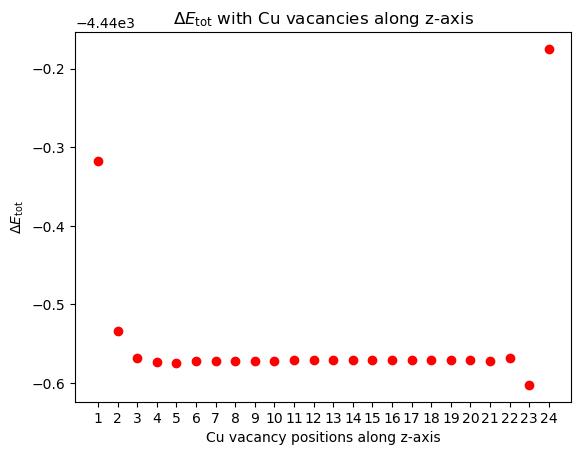

2025-05-20 16:40:31,699 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-20 16:40:31,700 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


sorted_Total_Energy_incl plot:


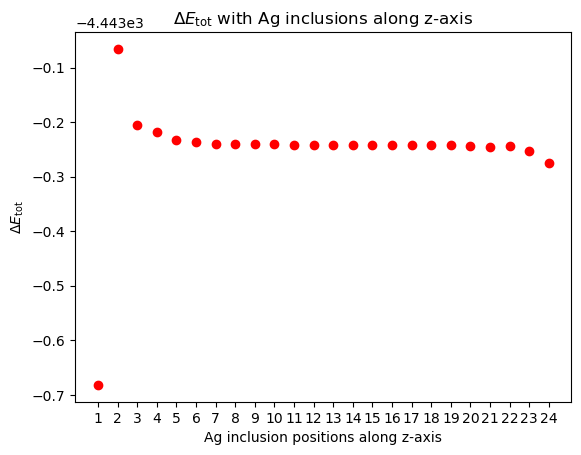

2025-05-20 16:40:31,827 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-20 16:40:31,828 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Energy_Delta_incl: [1.2930018498127538, 1.292837320783292, 1.292808103090465, 0.8519005605203347, 1.4683163432555375, 1.3296237841568654, 1.3157034840078268, 1.3005828222630953, 1.2969710350180321, 1.2946607748899623, 1.2938325861496196, 1.293225853972217, 1.2928776629678396, 1.2927947971011235, 1.292779627082382, 1.292733635767945, 1.2926378967122218, 1.2925755911210217, 1.2923751916441688, 1.2911104052845985, 1.2883260565122328, 1.2894860949263602, 1.2803827972174986, 1.2594317188468267];
24 Energy_Delta_incl list entrys
Energy_Delta_Vac: [4.216753197939397, 3.999473119409231, 3.965374950059413, 3.9612596430115445, 3.9597539073183725, 3.9614724402244974, 3.9618725869186164, 3.962251307326369, 3.962446099822955, 3.9625193472620595, 3.962551741394236, 3.9625654781593767, 3.9625726150215996, 3.9625775408967456, 3.9625851829259773, 3.9625950550416746, 3.96259437135177, 3.962626295076916, 3.9627991712959556, 3.9633631437882286, 3.9624387856683825, 3.9659869265933594, 3.9314714420588643, 4

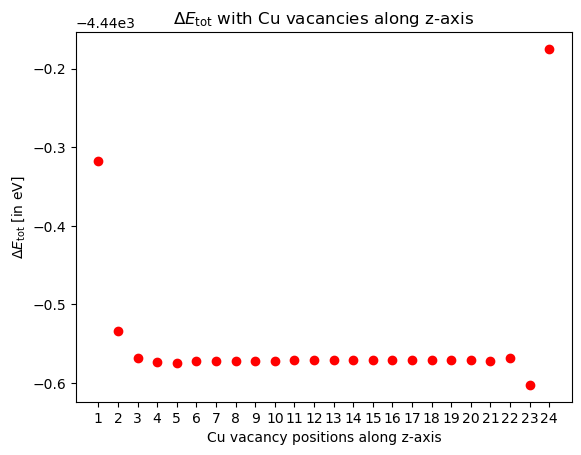

sorted_Total_Energy_Vac distance to GB plot:


ValueError: x and y must be the same size

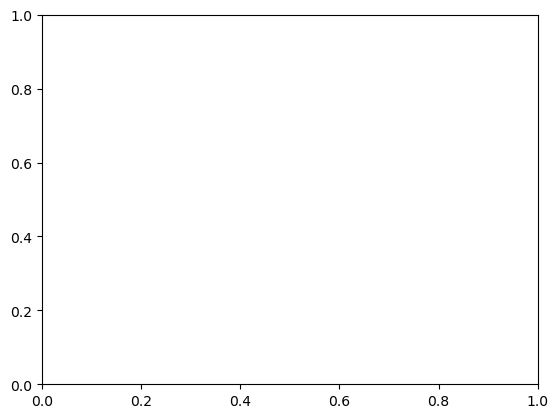

In [30]:
#To do

from collections import defaultdict
import re


# Ask the user for the LAMMPS index
LAMMPS_index = '011'
#LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#Section 1 read out energies from incl/Vac <----------------------------------------DONE NEEDS POLISH

incl = "Ag"

# Define the base directory
project_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model"
base_dir = f"{project_dir}/data/LAMMPS_Data"

# Clear preexisting variables
layer = []
layers = []
e_pot_Vac = []
Total_Energy_Vac = []
Total_Energy_Vac_per_atom = []
e_pot_incl = []
Total_Energy_incl = []
Total_Energy_incl_per_atom = []
e_pot_ref = []
Total_Energy_ref = []
Total_Energy_ref_per_atom = []
n_reps = []

"""
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []
"""

# List all directories in the base directory
base_path = Path(base_dir)


# Initialize dictionaries to store energies for both Vac and incl
vac_energies_dict = defaultdict(list)
incl_energies_dict = defaultdict(list)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

"""
# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_formation_energies_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)
"""

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue # Skip BULK files
    else:
        #TO DO split this one into 3 parts

        #Read out Vacancy versions:
        
        # If the folder does not contain "BULK", process the file
        print(Path(grandparent_folder))
        data_folder = grandparent_folder

        matchVac = re.search(r'(\d+)z-layers.*?Pos(\d+)-Vac\.mini\.data$', data_folder.name)
        
        if matchVac:
            #old:
            #layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_Vac_str)
            position = matchVac.group(2)  # Extract the position (e.g., Pos14)

            print(f"Confirm file: {f.name}")

            # Read the atoms data
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_Vac_uncorrected = atoms1.get_potential_energy()
            e_pot_Vac = Corrected_Energy(e_pot_Vac_uncorrected, atoms1)
            # Add to the vac_energies dictionary
            vac_energies_dict[position].append(e_pot_Vac)
            print("Supercell potential Energy:")
            print(e_pot_Vac, "eV")
            Total_Energy_Vac.append(e_pot_Vac)
        
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_Vac
            print(f"Undivided_Energy{Undivided_Energy}")
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_Vac_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print("Vac DONE\n")
            
        else:
            print(f"No Vac in folder name found")
            #continue  # Skip if no layer count is found
        
        #-----------------------------------------------------------------------------------------

        #old
        #matchincl = re.search(r'(\d+)z-layers.*?Pos\d+-Ag\.mini\.data$', data_folder.name)
        matchincl = re.search(r'(\d+)z-layers.*?Pos(\d+)-Ag\.mini\.data$', data_folder.name)

        #Read out incl versions:
        
        #replace Ag with incl  
        #new approach: # <------------------------------------------------------------------------------- OPEN
        #pattern = re.compile(r'(\d+)z-layers.*?Pos\d+-' + re.escape(incl) + r'\.mini\.data$')

        # Test filenames
        #filename1 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Ag.mini.data"
        #filename2 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Vac.mini.data"

        #print(bool(pattern.search(filename1)))  # ✅ True if incl = "Ag"
        #print(bool(pattern.search(filename2)))  # ❌ False if incl = "Ag"
        
        if matchincl:
            layers_incl_str = matchincl.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_incl_str)
            position = matchincl.group(2)  # Extract the position (e.g., Pos14)
            
            print(f"Confirm file: {f.name}")

            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_incl_uncorrected = atoms1.get_potential_energy()
            e_pot_incl = Corrected_Energy(e_pot_incl_uncorrected, atoms1)
            # Add to the incl_energies dictionary
            incl_energies_dict[position].append(e_pot_incl)

            print("Supercell potential Energy:")
            print(e_pot_incl, "eV")
            Total_Energy_incl.append(e_pot_incl)
            
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_incl
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_incl_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print(f"{incl} DONE\n")
            
        else:
            print(f"No {incl} in folder name found")
            #continue  # Skip if no layer count is found

        #---------------------------------------------------------------------------------------

        #OPEN read in reference Energy OPEN <-------------------------------------

        #look into If the folder does not contain "BULK" bzw "incl" or Vac, process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        # Replace with the actual path or folder object if needed
        data_folder_name = data_folder.name  # Assumes data_folder is a pathlib.Path or similar object

        # Exact match with folder name
        if data_folder_name == "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data":
            # Optional: extract the '36z' value if needed (not currently used)
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # or handle the error

            print(f"\n##############################################################################################################################")
            print(f"Confirm folder: {data_folder_name}")

            
            GB = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1: 31, 2: 29, 3: 47, 4: 34})
            atoms1.set_calculator(pot)

            n_reps.append(len(atoms1))

            e_pot_ref_uncorrected = atoms1.get_potential_energy()
            e_pot_ref = Corrected_Energy(e_pot_ref_uncorrected, atoms1)

            print("Supercell potential Energy:")
            print(e_pot_ref, "eV")
            Total_Energy_ref.append(e_pot_ref)

            Undivided_Energy = e_pot_ref
            Divided_Energy = Undivided_Energy / len(atoms1)
            Total_Energy_ref_per_atom.append(Divided_Energy)
        
            print(f"The Energy (per atom) is: {Divided_Energy} eV per atom")

            if layers:
                print(f"{layers} layers done\n")

            print("ref DONE")
            print(f"##############################################################################################################################\n")
        else:
            print("No Ref in folder name found")
        

        #-----------------------------------------------------------------------------------------
        #create dict (pos|energy)


        #-----------------------------------------------------------------------------------------


print("\n")
print(f"vac_energies_dict:\n{vac_energies_dict}\n") 
print(f"incl_energies_dict:\n{incl_energies_dict}\n") 

sorted_vac_energies_dict = sorted(vac_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"
sorted_incl_energies_dict = sorted(incl_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"

sorted_positions = []
sorted_Total_Energy_Vac = []
sorted_Total_Energy_incl = []

# Print out the sorted energies with their positions
print("\nVacancy Energies (Sorted by Position):")
for pos, energies in sorted_vac_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_Vac.append(energies[0])  #Extract the energy float value
    sorted_positions.append(pos)  #Extract the position int value

print("\nInclination Energies (Sorted by Position):")
for pos, energies in sorted_incl_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_incl.append(energies[0]) #Extract the float value

print(f"\nsorted_vac_energies_dict:\n{sorted_vac_energies_dict}\n") 
print(f"sorted_incl_energies_dict:\n{sorted_incl_energies_dict}\n") 

print("\n")
print("For comparison: old unsorted:")
print(f"Total_Energy_Vac:{Total_Energy_Vac};\n{len(Total_Energy_Vac)} Total_Energy_Vac list entrys")
print(f"Total_Energy_incl:{Total_Energy_incl};\n{len(Total_Energy_incl)} Total_Energy_incl list entrys")


print("\n")
print(f"sorted_positions:{sorted_positions};\n{len(sorted_positions)} sorted_positions list entrys")
print(f"sorted_Total_Energy_Vac:{sorted_Total_Energy_Vac};\n{len(sorted_Total_Energy_Vac)} sorted_Total_Energy_Vac list entrys")
print(f"sorted_Total_Energy_incl:{sorted_Total_Energy_incl};\n{len(sorted_Total_Energy_incl)} sorted_Total_Energy_incl list entrys")
print(f"Total_Energy_ref:{Total_Energy_ref};\n{len(Total_Energy_ref)} Total_Energy_ref list entrys")
print("\n")


#read out Total Energy for all 24 pos Vac | DONE
#24 values

#read out Total Energy for all 24 pos Ag/Cu? | DONE
#24 values

#read out Total Energy for reference | DONE
#1 value

#Quick plot:
print("sorted_Total_Energy_Vac plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print("sorted_Total_Energy_incl plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()


# Step 3:  Calculate Enegy Delta:

# Assuming Total_Energy_ref has only one value
ref_energy = Total_Energy_ref[0]

# Calculate delta lists
Energy_Delta_incl = [energy - ref_energy for energy in Total_Energy_incl]
Energy_Delta_Vac = [energy - ref_energy for energy in Total_Energy_Vac]

# Optional: print for confirmation
print(f"Energy_Delta_incl: {Energy_Delta_incl};\n{len(Energy_Delta_incl)} Energy_Delta_incl list entrys")
print(f"Energy_Delta_Vac: {Energy_Delta_Vac};\n{len(Energy_Delta_Vac)} Energy_Delta_Vac list entrys")
print("\n")

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

#Section 2 get distance of position <---------------------------------------------DONE


#find Ag pre for all 24 pos
#read files:
#create list:
incl_pos_pre = []

#find Vac pre from Ag pre (should be the same)
#read files:
#create list:
vac_pos_pre = []

#find Ag post for all 24 pos
#read files:
#create list:
incl_pos_post = []

#find Vac post for all 24 pos (is it the same?)
#read files:
#create list:
vac_pos_post = []


#Step 1: Find positions:

# Step 8.0 index Cu center to border:
#print("edit 1")
print(GB)
#reminder no screen elemnts outside of the office possible
#GB.edit()



# Problem: Shallow Copy: GB_revert = GB creates a shallow copy of GB. 
# This means both GB_revert and GB reference the same object (atoms list).
# Solution:
# Create a deep copy of GB
GB_revert = copy.deepcopy(GB)  # Make sure GB_revert is an independent copy
"""
print(GB_revert)
GB.edit()
"""

# Step 8.1 find center
center = find_center_of_atoms(GB)

# Step 8.2 find Cu pos closest to center
closest_atom_index, closest_atom_position = find_closest_atom_to_center(GB, center, "Cu")
#print(f"TEST: Closest Cu atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")

# Step 8.2.1 confirm Cu (replace with Bi)
ask_to_check_visuals = "skip"

GB_test1 = swap_atoms(GB, closest_atom_index, "Bi")
print(f"ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)")
ask_user_for_visuals(GB_test1, ask_to_check_visuals)

# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state

print(f"index center atom: {closest_atom_index}")

"""
print("edit 2")
print(GB_revert)
print(GB)
GB.edit()

print("\n\nExecution is being cancelled 1. Breaking the script.")
sys.exit()  # Exit the script immediately
"""


#Step 8.3 find Cu pos > center (in x or y tolerance room? 1 [x] strict \ \ \ \ pattern should not matter --> periodicity)
#and create index list: distance_to_center_index_list 
"""
#distance_to_center_index_list = [closest_atom_index]
#distance_to_center_index_list.append(next_atom_index)
#distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
"""
distance_to_center_index_list = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.5)    
print(f"distance_to_center_index_list = {distance_to_center_index_list}")

#Step 8.4 test version --> untill surface is hit (save atoms object as GB_incl_long)
GB_test2 = swap_atoms(GB, distance_to_center_index_list, "Bi")
#view(GB_test2)
print(f"ask_user_for_visuals for Step: 8.4 test version --> untill surface is hit")
ask_user_for_visuals(GB_test2, ask_to_check_visuals)
# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state
#print("edit 3")
#GB.edit()

print(f"\nindex list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")

# Extract z-positions of atoms at the given indices
z_positions = [GB[i].position[2] for i in distance_to_center_index_list]

# Sort the z-positions from small to large
sorted_z_positions = sorted(z_positions)

# Print the sorted z-positions
print(f"sorted_z_positions:\n {sorted_z_positions};\n{len(sorted_z_positions)} sorted_z_positions list entrys")
print(f"Closest Cu atom to center is at index {closest_atom_index} with coordinates: {closest_atom_position}")
print(f"center_z_position is {closest_atom_position[2]}")
#Closest Cu atom is at index 271 with coordinates: [  5.44242076  10.91675073 103.01715074]

#Step 2: get positon Delta (rel to center):
#calculate delta: [Pos pre]-[Pos post]??? (nessecary?) --> NO! Distance to Center Atom!!! (get center from function in ASE)!
#_pre or _post static relaxation pos? ==> select and print result Pre relax /post static / post MD

# Subtract the center z position from each sorted z position to get the delta (difference)
delta_z_positions = [z - closest_atom_position[2] for z in sorted_z_positions]
print(f"\ndelta_z_positions:\n {delta_z_positions};\n{len(delta_z_positions)} delta_z_positions list entrys")


#Section 3 plot <-----------------------------------------------------------------OPEN


#Quick plot:
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

#do both:



#Expressed as a DELTA to the energy value in the middle:
# Identifying the middle element (12th entry, index 11 in 0-based indexing)
Vac_ref = sorted_Total_Energy_Vac[11]
incl_ref = sorted_Total_Energy_incl[11]

# Computing the deltas for both lists relative to their respective references
sorted_Total_Energy_Vac_deltas = [x - Vac_ref for x in sorted_Total_Energy_Vac]
sorted_Total_Energy_incl_deltas = [x - incl_ref for x in sorted_Total_Energy_incl]

#print("sorted_Total_Energy_Vac_deltas:", sorted_Total_Energy_Vac_deltas)
#print("sorted_Total_Energy_incl_deltas:", sorted_Total_Energy_incl_deltas)
print(f"sorted_Total_Energy_Vac_deltas:\n {sorted_Total_Energy_Vac_deltas};\n{len(sorted_Total_Energy_Vac_deltas)} sorted_Total_Energy_Vac_deltas list entrys")
print(f"sorted_Total_Energy_incl_deltas:\n {sorted_Total_Energy_incl_deltas};\n{len(sorted_Total_Energy_incl_deltas)} sorted_Total_Energy_incl_deltas list entrys")

#Quick plot:
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

#do both:




# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

2025-05-20 13:10:23,501 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-20 13:10:23,503 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


sorted_positions:['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'];
24 sorted_positions list entrys
sorted_Total_Energy_Vac:[-4440.3170272927755, -4440.534307371306, -4440.5684055406555, -4440.572520847703, -4440.5740265833965, -4440.57230805049, -4440.571907903796, -4440.5715291833885, -4440.571334390892, -4440.571261143453, -4440.571228749321, -4440.5712150125555, -4440.571207875693, -4440.571202949818, -4440.571195307789, -4440.571185435673, -4440.571186119363, -4440.571154195638, -4440.570981319419, -4440.570417346927, -4440.5713417050465, -4440.5677935641215, -4440.602309048656, -4440.1749767181645];
24 sorted_Total_Energy_Vac list entrys
sorted_Total_Energy_incl:[-4443.681879930195, -4443.065464147459, -4443.204156706558, -4443.218077006707, -4443.233197668452, -4443.236809455697, -4443.239119715825, -4443.239947904565, -4443.240554636743, -4443.240778640902, -4443.240902827747, -4443.2409431699

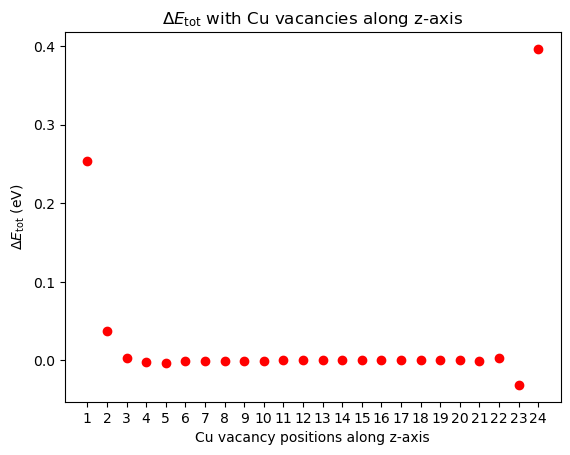

sorted_Total_Energy_Vac distance to GB plot:


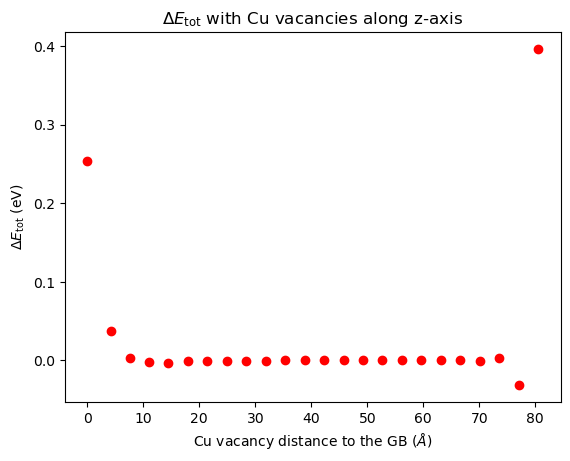



sorted_Total_Energy_incl positions along z-axis plot:


2025-05-20 13:10:23,704 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-20 13:10:23,705 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


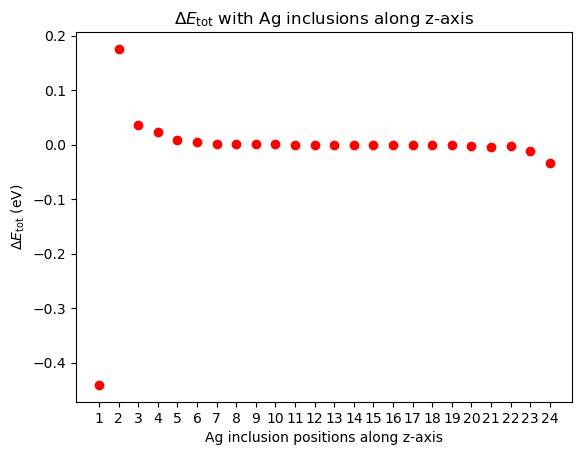

sorted_Total_Energy_incl distance to GB plot:


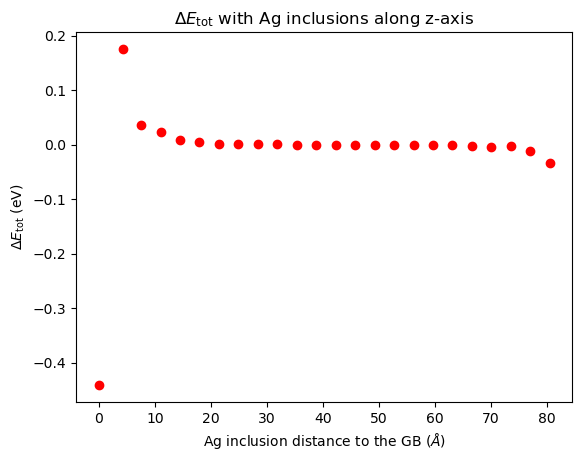

2025-05-20 13:10:23,966 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-20 13:10:23,967 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.




sorted_Total_Energy_incl positions along z-axis plot:


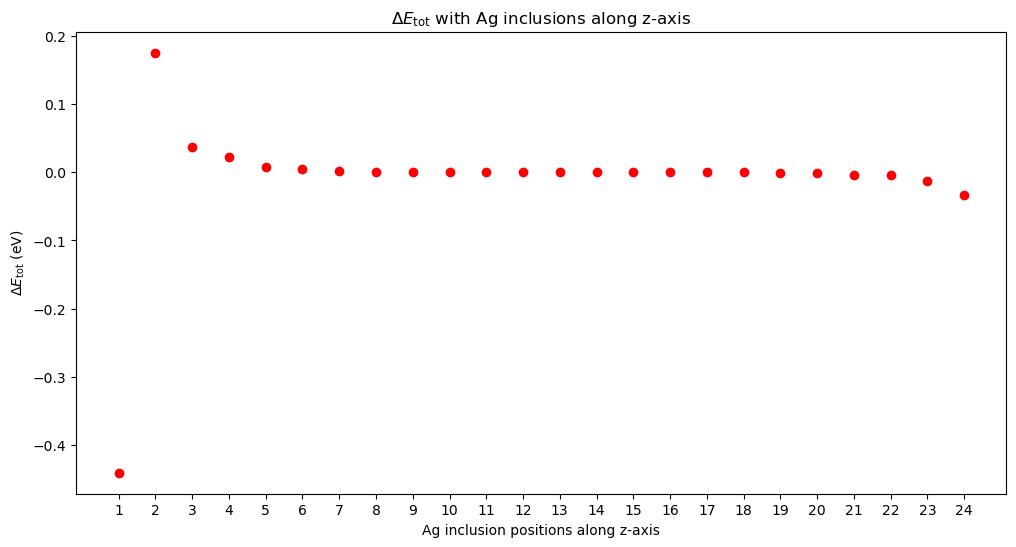

sorted_Total_Energy_incl distance to GB plot:


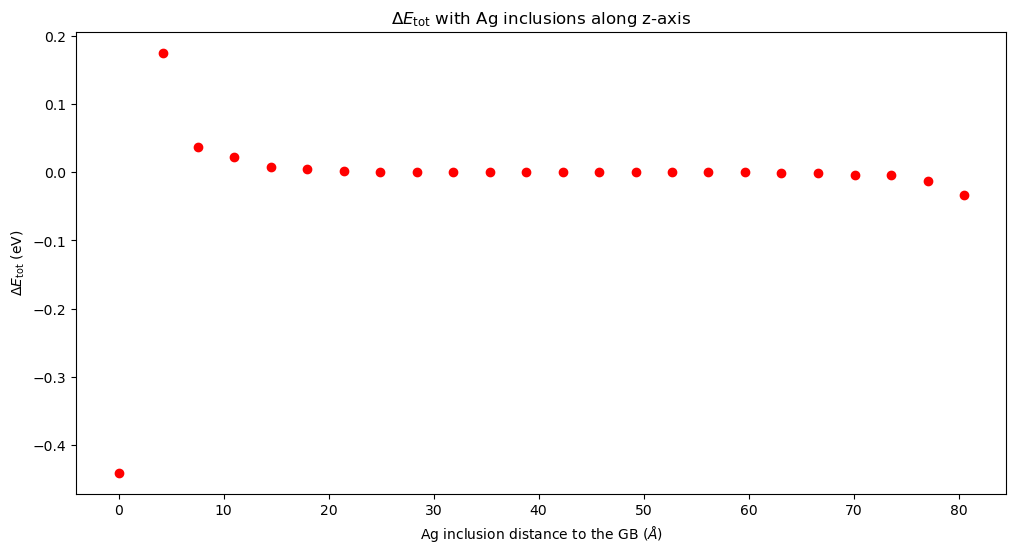

2025-05-20 13:10:24,199 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-20 13:10:24,200 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.




sorted_Total_Energy_incl positions along z-axis plot:


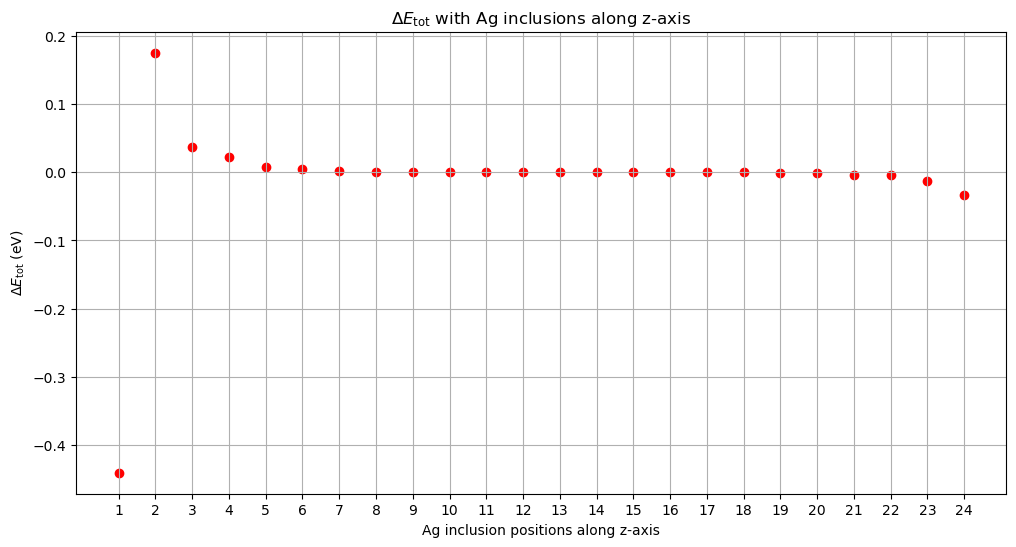

sorted_Total_Energy_incl distance to GB plot:


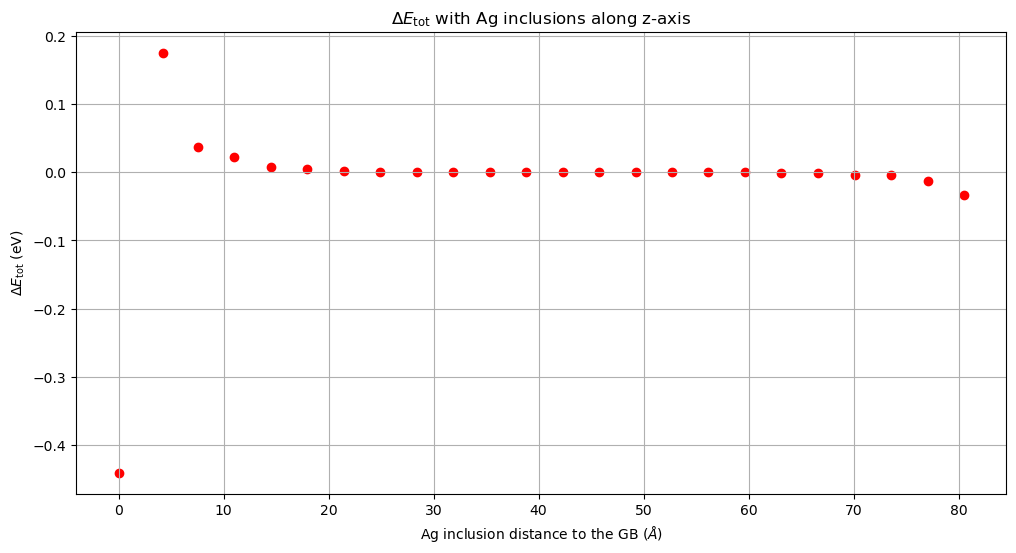

2025-05-20 13:10:24,436 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-20 13:10:24,436 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.




sorted_Total_Energy_Vac positions along z-axis plot:


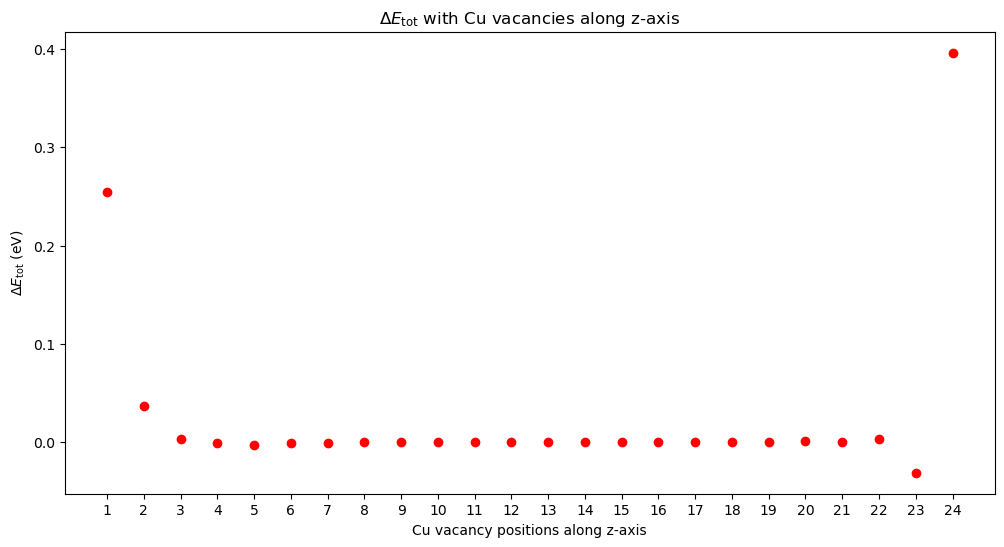

sorted_Total_Energy_Vac distance to GB plot:


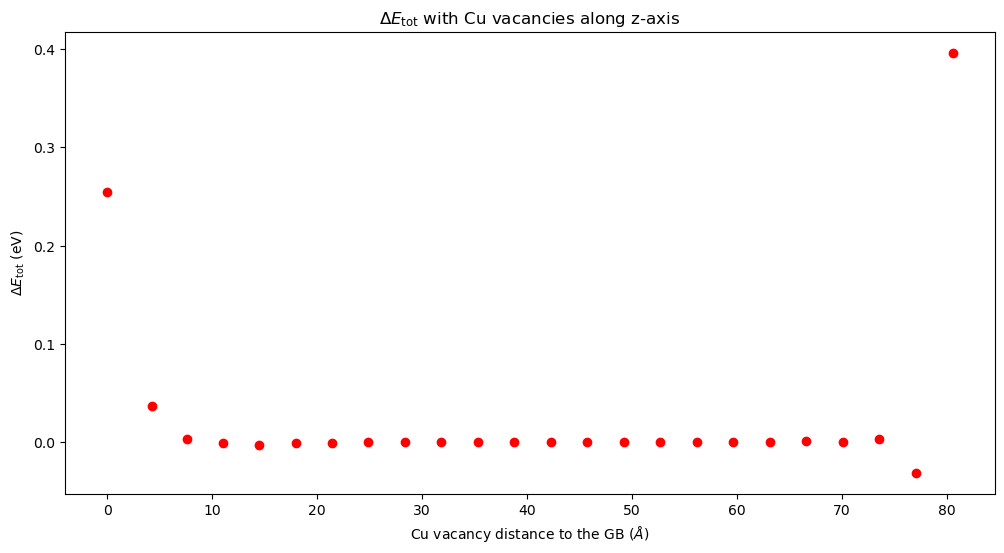

In [11]:
print(f"sorted_positions:{sorted_positions};\n{len(sorted_positions)} sorted_positions list entrys")
print(f"sorted_Total_Energy_Vac:{sorted_Total_Energy_Vac};\n{len(sorted_Total_Energy_Vac)} sorted_Total_Energy_Vac list entrys")
print(f"sorted_Total_Energy_incl:{sorted_Total_Energy_incl};\n{len(sorted_Total_Energy_incl)} sorted_Total_Energy_incl list entrys")
print(f"Total_Energy_ref:{Total_Energy_ref};\n{len(Total_Energy_ref)} Total_Energy_ref list entrys")
print("\n")

print("sorted_Total_Energy_Vac_deltas:\n", sorted_Total_Energy_Vac_deltas)
print("sorted_Total_Energy_incl_deltas:\n", sorted_Total_Energy_incl_deltas)
print("\n")

#Quick plot:
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()


print("\n")
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()


print("\n")
# Wide plot for sorted_Total_Energy_incl positions along z-axis
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

# Wide plot for sorted_Total_Energy_incl distance to GB
print("sorted_Total_Energy_incl distance to GB plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

#----------------------------------------------------------------------------------
print("\n")
# Wide plot for sorted_Total_Energy_incl positions along z-axis
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.grid(True)  # Optional: Add grid for better readability
plt.show()

# Wide plot for sorted_Total_Energy_incl distance to GB
print("sorted_Total_Energy_incl distance to GB plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.grid(True)  # Optional: Add grid for better readability
plt.show()
#----------------------------------------------------------------------------------

print("\n")
#Quick plot:
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(sorted_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

In [ ]:












#new readout 017 and up
















Enter the LAMMPS index (e.g., 001, 002, ... etc.):  021


Folder name for 021 is: LAMMPS_Submision_021_20-05-2025_13-51-09
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_021_20-05-2025_13-51-09/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_3wide_20A-VACUUMS_Pos1-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data


/tmp/ipykernel_2222965/1796556818.py:171: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-13036.277966501442 eV
The Energy (per atom) is: -3.852328004285296 in eV per atom
Position: Pos1
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_021_20-05-2025_13-51-09/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_3wide_20A-VACUUMS_Pos1-Ag.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_021_20-05-2025_13-51-09/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_3wide_20A-VACUUMS_Pos2-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data
Supercell potential Energy:
-13036.240095738916 eV
The Energy (per atom) is: -3.852316813161618 in eV per atom
Position: Pos2
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_021_20-05-2025_13-51-09/31_Submited_mini_data_folde

/tmp/ipykernel_2222965/1796556818.py:118: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-13033.151202144014 eV
Undivided_Energy-13033.151202144014
The Energy (per atom) is: -3.8525424777251 in eV per atom
Position: Pos1
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_021_20-05-2025_13-51-09/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_3wide_20A-VACUUMS_Pos1-Vac.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_021_20-05-2025_13-51-09/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_3wide_20A-VACUUMS_Pos2-Vac.mini.data
Confirm file: optimize1.data
Supercell potential Energy:
-13033.580813687453 eV
Undivided_Energy-13033.580813687453
The Energy (per atom) is: -3.8526694690178696 in eV per atom
Position: Pos2
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Interse

/tmp/ipykernel_2222965/1796556818.py:261: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)
2025-05-26 19:13:00,864 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 19:13:00,866 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Supercell potential Energy:
-13037.510946357868 eV
The Energy (per atom) is: -3.852692360034831 eV per atom
12 layers done

ref DONE
##############################################################################################################################



vac_energies_dict:
defaultdict(<class 'list'>, {'1': [-13033.151202144014], '2': [-13033.580813687453], '3': [-13033.547702952692], '4': [-13033.552400450984], '5': [-13033.552676230065], '6': [-13033.545172445702], '7': [-13033.50711954177], '8': [-13033.254180576449], '9': [-13033.50711954176], '10': [-13033.545172445662], '11': [-13033.552676230065], '12': [-13033.552400450963], '13': [-13033.547702952694], '14': [-13033.580658843774], '15': [-13033.151202144065]})

incl_energies_dict:
defaultdict(<class 'list'>, {'1': [-13036.277966501442], '2': [-13036.240095738916], '3': [-13036.230859796315], '4': [-13036.228377487238], '5': [-13036.211040805885], '6': [-13036.197147624252], '7': [-13036.058548694753], '8': [-13036.65655

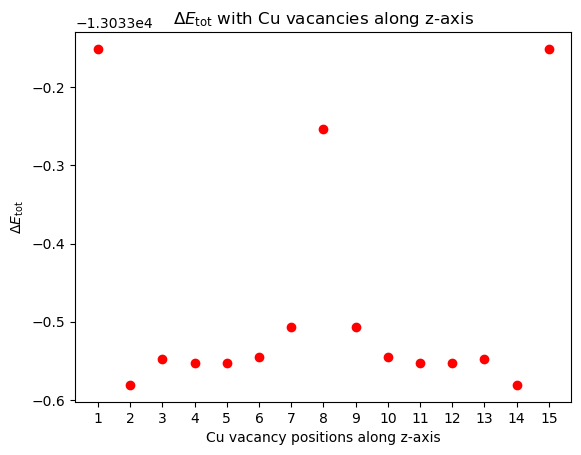

2025-05-26 19:13:01,023 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 19:13:01,025 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


sorted_Total_Energy_incl plot:


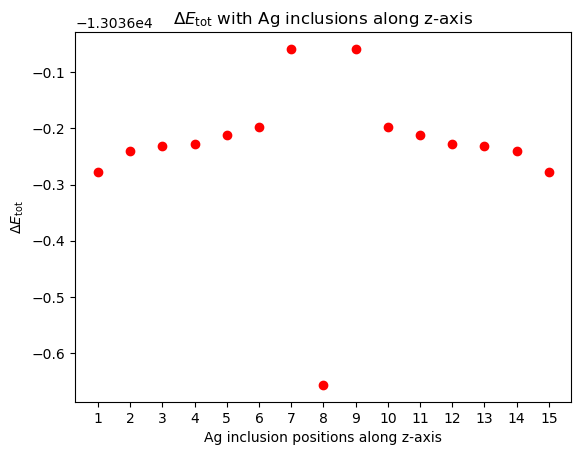

Energy_Delta_incl: [1.2329798564260273, 1.270850618951954, 1.2800865615536168, 1.282568870630712, 1.2999055519831018, 1.3137987336158403, 1.4523976631153346, 0.854390972528563, 1.4523976630935067, 1.3137987336122023, 1.2999055519976537, 1.2825688706525398, 1.280086561517237, 1.270850618937402, 1.2329981071634393];
15 Energy_Delta_incl list entrys
Energy_Delta_Vac: [4.359744213854356, 3.9301326704153325, 3.9632434051763994, 3.9585459068839555, 3.958270127803189, 3.9657739121666964, 4.003826816098808, 4.256765781419745, 4.003826816107903, 3.965773912206714, 3.958270127803189, 3.9585459069057833, 3.9632434051745804, 3.9302875140947435, 4.359744213803424];
15 Energy_Delta_Vac list entrys


Atoms(symbols='Cu846Ga846Se1692', pbc=True, cell=[24.018160754184322, 58.86994573368153, 95.29105450343366], id=..., masses=..., momenta=..., type=...)
Center of the atoms: [12.03037307 29.42582752 48.16177399]
Closest Cu atom is at index 351 with coordinates: [13.44694806 30.61666549 47.72654423]
The va

2025-05-26 19:13:01,254 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 19:13:01,256 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


distance_to_center_index_list_part2 = [367, 368, 384, 386, 393, 394, 576]
distance_to_center_index_list = [345, 318, 314, 303, 299, 293, 0, 351, 367, 368, 384, 386, 393, 394, 576]
The variable is a list: [345, 318, 314, 303, 299, 293, 0, 351, 367, 368, 384, 386, 393, 394, 576]
Swapping atom at index 576: Atom('Cu', [12.663639227946712, 30.65113576616401, 69.16247616506243], momentum=[0.0, 0.0, 0.0], mass=63.54600001634684, index=576) with Bi
Swapping atom at index 394: Atom('Cu', [12.663908015372662, 30.63995336953825, 62.216957445247374], momentum=[0.0, 0.0, 0.0], mass=63.54600001634684, index=394) with Bi
Swapping atom at index 393: Atom('Cu', [14.66248652636483, 30.629314675638707, 58.75607226015891], momentum=[0.0, 0.0, 0.0], mass=63.54600001634684, index=393) with Bi
Swapping atom at index 386: Atom('Cu', [14.743820714940842, 30.80589657486075, 72.64492039786779], momentum=[0.0, 0.0, 0.0], mass=63.54600001634684, index=386) with Bi
Swapping atom at index 384: Atom('Cu', [14.666057

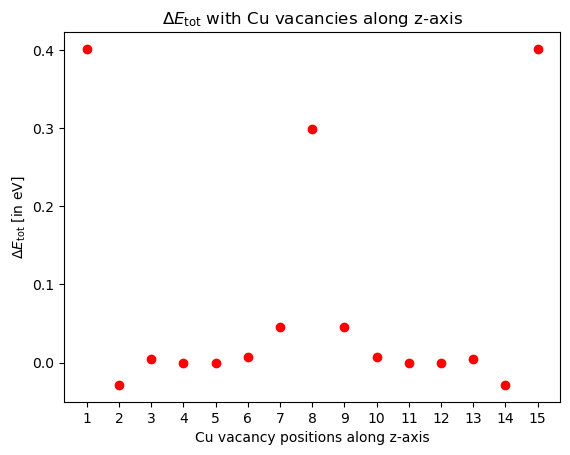

sorted_Total_Energy_Vac distance to GB plot:


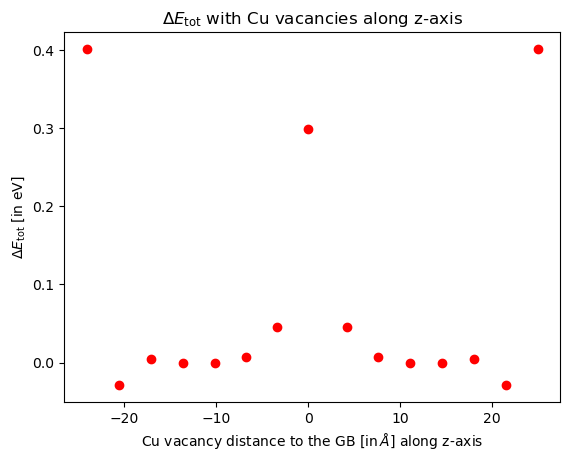

2025-05-26 19:13:02,184 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 19:13:02,186 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


sorted_Total_Energy_incl positions along z-axis plot:


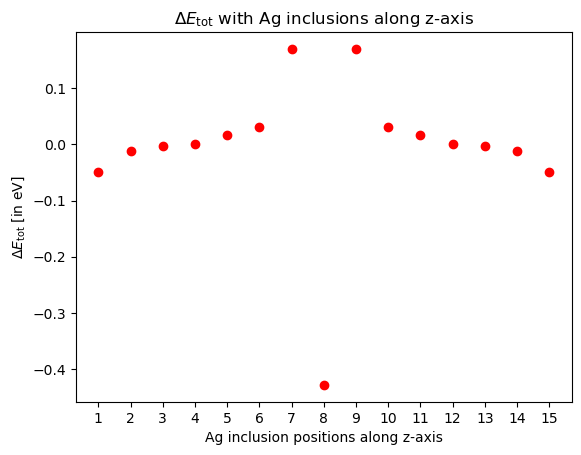

sorted_Total_Energy_incl distance to GB plot:


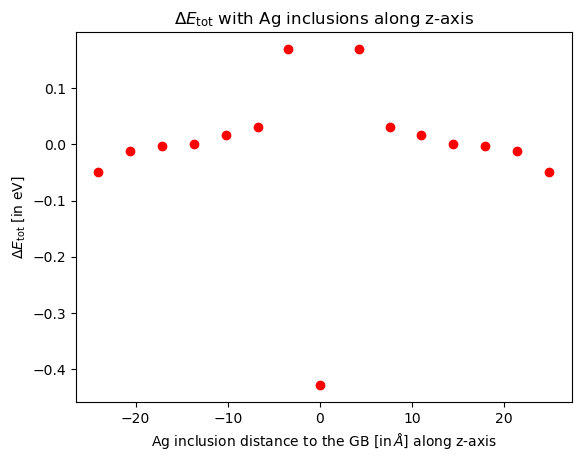

021_entries_SAVED

021_part1_DONE

Timestamp:
26-05-2025 19:13


In [21]:
#To do

from collections import defaultdict
import re


# Ask the user for the LAMMPS index
#LAMMPS_index = '011'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#Section 1 read out energies from incl/Vac <----------------------------------------DONE NEEDS POLISH

incl = "Ag"

# Define the base directory
project_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model"
base_dir = f"{project_dir}/data/LAMMPS_Data"

# Clear preexisting variables
layer = []
layers = []
e_pot_Vac = []
Total_Energy_Vac = []
Total_Energy_Vac_per_atom = []
e_pot_incl = []
Total_Energy_incl = []
Total_Energy_incl_per_atom = []
e_pot_ref = []
Total_Energy_ref = []
Total_Energy_ref_per_atom = []
n_reps = []

"""
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []
"""

# List all directories in the base directory
base_path = Path(base_dir)


# Initialize dictionaries to store energies for both Vac and incl
vac_energies_dict = defaultdict(list)
incl_energies_dict = defaultdict(list)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

"""
# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_formation_energies_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)
"""

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue # Skip BULK files
    else:
        #TO DO split this one into 3 parts

        #Read out Vacancy versions:
        
        # If the folder does not contain "BULK", process the file
        print(Path(grandparent_folder))
        data_folder = grandparent_folder

        matchVac = re.search(r'(\d+)z-layers.*?Pos(\d+)-Vac\.mini\.data$', data_folder.name)
        
        if matchVac:
            #old:
            #layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_Vac_str)
            position = matchVac.group(2)  # Extract the position (e.g., Pos14)

            print(f"Confirm file: {f.name}")

            # Read the atoms data
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_Vac_uncorrected = atoms1.get_potential_energy()
            e_pot_Vac = Corrected_Energy(e_pot_Vac_uncorrected, atoms1)
            # Add to the vac_energies dictionary
            vac_energies_dict[position].append(e_pot_Vac)
            print("Supercell potential Energy:")
            print(e_pot_Vac, "eV")
            Total_Energy_Vac.append(e_pot_Vac)
        
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_Vac
            print(f"Undivided_Energy{Undivided_Energy}")
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_Vac_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print("Vac DONE\n")
            
        else:
            print(f"No Vac in folder name found")
            #continue  # Skip if no layer count is found
        
        #-----------------------------------------------------------------------------------------

        #old
        #matchincl = re.search(r'(\d+)z-layers.*?Pos\d+-Ag\.mini\.data$', data_folder.name)
        matchincl = re.search(r'(\d+)z-layers.*?Pos(\d+)-Ag\.mini\.data$', data_folder.name)

        #Read out incl versions:
        
        #replace Ag with incl  
        #new approach: # <------------------------------------------------------------------------------- OPEN
        #pattern = re.compile(r'(\d+)z-layers.*?Pos\d+-' + re.escape(incl) + r'\.mini\.data$')

        # Test filenames
        #filename1 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Ag.mini.data"
        #filename2 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Vac.mini.data"

        #print(bool(pattern.search(filename1)))  # ✅ True if incl = "Ag"
        #print(bool(pattern.search(filename2)))  # ❌ False if incl = "Ag"
        
        if matchincl:
            layers_incl_str = matchincl.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_incl_str)
            position = matchincl.group(2)  # Extract the position (e.g., Pos14)
            
            print(f"Confirm file: {f.name}")

            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_incl_uncorrected = atoms1.get_potential_energy()
            e_pot_incl = Corrected_Energy(e_pot_incl_uncorrected, atoms1)
            # Add to the incl_energies dictionary
            incl_energies_dict[position].append(e_pot_incl)

            print("Supercell potential Energy:")
            print(e_pot_incl, "eV")
            Total_Energy_incl.append(e_pot_incl)
            
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_incl
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_incl_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print(f"{incl} DONE\n")
            
        else:
            print(f"No {incl} in folder name found")
            #continue  # Skip if no layer count is found

        #---------------------------------------------------------------------------------------

        #OPEN read in reference Energy OPEN <-------------------------------------

        #look into If the folder does not contain "BULK" bzw "incl" or Vac, process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        # Replace with the actual path or folder object if needed
        data_folder_name = data_folder.name  # Assumes data_folder is a pathlib.Path or similar object

        
        # Exact match with folder name
        """
        if data_folder_name == "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data":
        #if data_folder_name == "0_print_steps_CuGaSe2_GB_S9_12z-layers.mini.data":
            # Optional: extract the '36z' value if needed (not currently used)
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # or handle the error
                
        """

        '''
        # Match ONLY files like: 0_anything_CuGaSe2_..._z-layers_20A-VACUUMS.mini.data
        # and explicitly exclude ones that continue with "_pos" or other suffixes before .mini.data
        match_ref = re.match(r"0_.*CuGaSe2.*z-layers_20A-VACUUMS\.mini\.data$", data_folder_name)

        if match_ref:
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # Optional: fallback or warning
        '''
        
        # Match files that:
        # - start with 0_
        # - contain CuGaSe2
        # - end with .mini.data
        # - but do NOT contain "-Ag", "-Vac", or "Pos<digits>" anywhere
        is_reference_file = (
            data_folder_name.startswith("0_")
            and "CuGaSe2" in data_folder_name
            and data_folder_name.endswith(".mini.data")
            and not re.search(r"(Pos\d+|-Ag|-Vac)", data_folder_name)
        )
        
        if is_reference_file:
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # Or handle this more explicitly if needed
      
        
            print(f"\n##############################################################################################################################")
            print(f"Confirm folder: {data_folder_name}")

            
            GB = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1: 31, 2: 29, 3: 47, 4: 34})
            atoms1.set_calculator(pot)

            n_reps.append(len(atoms1))

            e_pot_ref_uncorrected = atoms1.get_potential_energy()
            e_pot_ref = Corrected_Energy(e_pot_ref_uncorrected, atoms1)

            print("Supercell potential Energy:")
            print(e_pot_ref, "eV")
            Total_Energy_ref.append(e_pot_ref)

            Undivided_Energy = e_pot_ref
            Divided_Energy = Undivided_Energy / len(atoms1)
            Total_Energy_ref_per_atom.append(Divided_Energy)
        
            print(f"The Energy (per atom) is: {Divided_Energy} eV per atom")

            if layers:
                print(f"{layers} layers done\n")

            print("ref DONE")
            print(f"##############################################################################################################################\n")
        else:
            print("No Ref in folder name found")
        

        #-----------------------------------------------------------------------------------------
        #create dict (pos|energy)


        #-----------------------------------------------------------------------------------------


print("\n")
print(f"vac_energies_dict:\n{vac_energies_dict}\n") 
print(f"incl_energies_dict:\n{incl_energies_dict}\n") 

sorted_vac_energies_dict = sorted(vac_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"
sorted_incl_energies_dict = sorted(incl_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"

sorted_positions = []
sorted_Total_Energy_Vac = []
sorted_Total_Energy_incl = []

# Print out the sorted energies with their positions
print("\nVacancy Energies (Sorted by Position):")
for pos, energies in sorted_vac_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_Vac.append(energies[0])  #Extract the energy float value
    sorted_positions.append(pos)  #Extract the position int value

print("\nInclination Energies (Sorted by Position):")
for pos, energies in sorted_incl_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_incl.append(energies[0]) #Extract the float value

print(f"\nsorted_vac_energies_dict:\n{sorted_vac_energies_dict}\n") 
print(f"sorted_incl_energies_dict:\n{sorted_incl_energies_dict}\n") 

print("\n")
print("For comparison: old unsorted:")
print(f"Total_Energy_Vac:{Total_Energy_Vac};\n{len(Total_Energy_Vac)} Total_Energy_Vac list entrys")
print(f"Total_Energy_incl:{Total_Energy_incl};\n{len(Total_Energy_incl)} Total_Energy_incl list entrys")


print("\n")
print(f"sorted_positions:{sorted_positions};\n{len(sorted_positions)} sorted_positions list entrys")
print(f"sorted_Total_Energy_Vac:{sorted_Total_Energy_Vac};\n{len(sorted_Total_Energy_Vac)} sorted_Total_Energy_Vac list entrys")
print(f"sorted_Total_Energy_incl:{sorted_Total_Energy_incl};\n{len(sorted_Total_Energy_incl)} sorted_Total_Energy_incl list entrys")
print(f"Total_Energy_ref:{Total_Energy_ref};\n{len(Total_Energy_ref)} Total_Energy_ref list entrys")
print("\n")


#read out Total Energy for all 24 pos Vac | DONE
#24 values

#read out Total Energy for all 24 pos Ag/Cu? | DONE
#24 values

#read out Total Energy for reference | DONE
#1 value


#Quick plot:
print("sorted_Total_Energy_Vac plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print("sorted_Total_Energy_incl plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()


# Step 3:  Calculate Enegy Delta:

# Assuming Total_Energy_ref has only one value
ref_energy = Total_Energy_ref[0]

# Calculate delta lists
Energy_Delta_incl = [energy - ref_energy for energy in Total_Energy_incl]
Energy_Delta_Vac = [energy - ref_energy for energy in Total_Energy_Vac]

# Optional: print for confirmation
print(f"Energy_Delta_incl: {Energy_Delta_incl};\n{len(Energy_Delta_incl)} Energy_Delta_incl list entrys")
print(f"Energy_Delta_Vac: {Energy_Delta_Vac};\n{len(Energy_Delta_Vac)} Energy_Delta_Vac list entrys")
print("\n")

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

#Section 2 get distance of position <---------------------------------------------DONE


#find Ag pre for all 24 pos
#read files:
#create list:
incl_pos_pre = []

#find Vac pre from Ag pre (should be the same)
#read files:
#create list:
vac_pos_pre = []

#find Ag post for all 24 pos
#read files:
#create list:
incl_pos_post = []

#find Vac post for all 24 pos (is it the same?)
#read files:
#create list:
vac_pos_post = []


#Step 1: Find positions:

# Step 8.0 index Cu center to border:
#print("edit 1")
print(GB)
#reminder no screen elemnts outside of the office possible
#GB.edit()


######################################################################################################################################
# Problem: Shallow Copy: GB_revert = GB creates a shallow copy of GB. 
# This means both GB_revert and GB reference the same object (atoms list).
# Solution:
# Create a deep copy of GB
GB_revert = copy.deepcopy(GB)  # Make sure GB_revert is an independent copy
"""
print(GB_revert)
GB.edit()
"""

# Step 8.1 find center
center = find_center_of_atoms(GB)

# Step 8.2 find Cu pos closest to center
closest_atom_index, closest_atom_position = find_closest_atom_to_center(GB, center, "Cu")
#print(f"TEST: Closest Cu atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")

# Step 8.2.1 confirm Cu (replace with Bi)
ask_to_check_visuals = "skip"

GB_test1 = swap_atoms(GB, closest_atom_index, "Bi")
print(f"ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)")
ask_user_for_visuals(GB_test1, ask_to_check_visuals)

# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state

print(f"index center atom: {closest_atom_index}")

"""
print("edit 2")
print(GB_revert)
print(GB)
GB.edit()

print("\n\nExecution is being cancelled 1. Breaking the script.")
sys.exit()  # Exit the script immediately
"""


#Step 8.3 find Cu pos > center (in x or y tolerance room? 1 [x] strict \ \ \ \ pattern should not matter --> periodicity)
#and create index list: distance_to_center_index_list 
"""
#distance_to_center_index_list = [closest_atom_index]
#distance_to_center_index_list.append(next_atom_index)
#distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
"""

#Step 1.4 create index list: distance_to_center_index_list 
distance_to_center_index_list = []
distance_to_center_index_list_1 = []
distance_to_center_index_list_2 = []

#XHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXH

#def get_atoms_with_smaller_z(atoms, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance=0.1):
distance_to_center_index_list_1 = get_atoms_with_smaller_z(GB, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance= 0.7, x_tolerance = 3) 
distance_to_center_index_list_1.reverse()
print(f"distance_to_center_index_list_part1 = {distance_to_center_index_list_1}")

closest_atom_index_list = [closest_atom_index]
print(f"closest_atom_index_list (to center) = {closest_atom_index_list}")

distance_to_center_index_list_2 = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.7, x_tolerance = 3)    
print(f"distance_to_center_index_list_part2 = {distance_to_center_index_list_2}")

distance_to_center_index_list = distance_to_center_index_list_1 + closest_atom_index_list + distance_to_center_index_list_2
print(f"distance_to_center_index_list = {distance_to_center_index_list}")


#distance_to_center_index_list = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.5)    
#print(f"distance_to_center_index_list = {distance_to_center_index_list}")


#XHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXH




#Step 8.4 test version --> untill surface is hit (save atoms object as GB_incl_long)
ask_to_check_visuals = "skip"
#ask_to_check_visuals = "ask"
GB_test2 = swap_atoms(GB, distance_to_center_index_list, "Bi")
#view(GB_test2)
print(f"ask_user_for_visuals for Step: 8.4 test version --> untill surface is hit")
ask_user_for_visuals(GB_test2, ask_to_check_visuals)
# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state
#print("edit 3")
#GB.edit()

#print(f"index list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")
print(f"\nindex list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")

# Extract z-positions of atoms at the given indices
z_positions = [GB[i].position[2] for i in distance_to_center_index_list]

# Sort the z-positions from small to large
sorted_z_positions = sorted(z_positions)

# Print the sorted z-positions
print(f"sorted_z_positions:\n {sorted_z_positions};\n{len(sorted_z_positions)} sorted_z_positions list entrys")
print(f"Closest Cu atom to center is at index {closest_atom_index} with coordinates: {closest_atom_position}")
print(f"center_z_position is {closest_atom_position[2]}")
#Closest Cu atom is at index 271 with coordinates: [  5.44242076  10.91675073 103.01715074]


#Step 2: get positon Delta (rel to center):
#calculate delta: [Pos pre]-[Pos post]??? (nessecary?) --> NO! Distance to Center Atom!!! (get center from function in ASE)!
#_pre or _post static relaxation pos? ==> select and print result Pre relax /post static / post MD

# Subtract the center z position from each sorted z position to get the delta (difference)
delta_z_positions = [z - closest_atom_position[2] for z in sorted_z_positions]
print(f"\ndelta_z_positions:\n {delta_z_positions};\n{len(delta_z_positions)} delta_z_positions list entrys")



######################################################################################################################################

#Section 3 plot

# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_segregation_energies_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)

print(f"sorted_Total_Energy_Vac:\n{sorted_Total_Energy_Vac}")
print(f"sorted_Total_Energy_incl:\n{sorted_Total_Energy_incl}")
print(f"delta_z_positions:\n{delta_z_positions}")
print(f"sorted_positions:\n{sorted_positions}")

"""
#Quick plot:
#vacancies
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energies_pos.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energies_pos.png", bbox_inches='tight') 
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energies_distance.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energies_distance.png", bbox_inches='tight') 
plt.show()


#incl
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energies_pos.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energies_pos.png", bbox_inches='tight') 
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energies_distance.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energies_distance.png", bbox_inches='tight') 
plt.show()
"""




#Expressed as a DELTA to the energy value in the middle:
# Identifying the middle element (12th entry, index 11 in 0-based indexing)
Vac_ref = sorted_Total_Energy_Vac[11]
incl_ref = sorted_Total_Energy_incl[11]

# Computing the deltas for both lists relative to their respective references
sorted_Total_Energy_Vac_deltas = [x - Vac_ref for x in sorted_Total_Energy_Vac]
sorted_Total_Energy_incl_deltas = [x - incl_ref for x in sorted_Total_Energy_incl]


#print("sorted_Total_Energy_Vac_deltas:", sorted_Total_Energy_Vac_deltas)
#print("sorted_Total_Energy_incl_deltas:", sorted_Total_Energy_incl_deltas)
print(f"sorted_Total_Energy_Vac_deltas:\n {sorted_Total_Energy_Vac_deltas};\n{len(sorted_Total_Energy_Vac_deltas)} sorted_Total_Energy_Vac_deltas list entrys")
print(f"sorted_Total_Energy_incl_deltas:\n {sorted_Total_Energy_incl_deltas};\n{len(sorted_Total_Energy_incl_deltas)} sorted_Total_Energy_incl_deltas list entrys")


#Quick plot:
#Vacancies
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.show()


#Inclusions (silver solvents)
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.show()

#do both:

"""
# Show the plot
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}Segregation_Energies.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}Segregation_Energies.png", bbox_inches='tight') 
plt.show()
"""

#Addendum: fix Energy and position lists as Global Variables:
#on problem try copy.deepcopy(sorted_positions)
if LAMMPS_index == "017":
    sorted_positions_017 = sorted_positions
    delta_z_positions_017 = delta_z_positions
    sorted_Total_Energy_Vac_deltas_017 = sorted_Total_Energy_Vac_deltas
    sorted_Total_Energy_incl_deltas_017 = sorted_Total_Energy_incl_deltas
    print(f"{LAMMPS_index}_entries_SAVED\n")

if LAMMPS_index == "018":
    sorted_positions_018 = sorted_positions
    delta_z_positions_018 = delta_z_positions
    sorted_Total_Energy_Vac_deltas_018 = sorted_Total_Energy_Vac_deltas
    sorted_Total_Energy_incl_deltas_018 = sorted_Total_Energy_incl_deltas
    print(f"{LAMMPS_index}_entries_SAVED\n")

if LAMMPS_index == "019":
    sorted_positions_019 = sorted_positions
    delta_z_positions_019 = delta_z_positions
    sorted_Total_Energy_Vac_deltas_019 = sorted_Total_Energy_Vac_deltas
    sorted_Total_Energy_incl_deltas_019 = sorted_Total_Energy_incl_deltas
    print(f"{LAMMPS_index}_entries_SAVED\n")

if LAMMPS_index == "020":
    sorted_positions_020 = sorted_positions
    delta_z_positions_020 = delta_z_positions
    sorted_Total_Energy_Vac_deltas_020 = sorted_Total_Energy_Vac_deltas
    sorted_Total_Energy_incl_deltas_020 = sorted_Total_Energy_incl_deltas
    print(f"{LAMMPS_index}_entries_SAVED\n")

if LAMMPS_index == "021":
    sorted_positions_021 = sorted_positions
    delta_z_positions_021 = delta_z_positions
    sorted_Total_Energy_Vac_deltas_021 = sorted_Total_Energy_Vac_deltas
    sorted_Total_Energy_incl_deltas_021 = sorted_Total_Energy_incl_deltas
    print(f"{LAMMPS_index}_entries_SAVED\n")

if LAMMPS_index == "022":
    sorted_positions_022 = sorted_positions
    delta_z_positions_022 = delta_z_positions
    sorted_Total_Energy_Vac_deltas_022 = sorted_Total_Energy_Vac_deltas
    sorted_Total_Energy_incl_deltas_022 = sorted_Total_Energy_incl_deltas
    print(f"{LAMMPS_index}_entries_SAVED\n")

print(f"{LAMMPS_index}_part1_DONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [12]:
# print(f"sorted_positions:{sorted_positions};\n{len(sorted_positions)} sorted_positions list entrys")
print(f"sorted_Total_Energy_Vac:{sorted_Total_Energy_Vac};\n{len(sorted_Total_Energy_Vac)} sorted_Total_Energy_Vac list entrys")
print(f"sorted_Total_Energy_incl:{sorted_Total_Energy_incl};\n{len(sorted_Total_Energy_incl)} sorted_Total_Energy_incl list entrys")
print(f"Total_Energy_ref:{Total_Energy_ref};\n{len(Total_Energy_ref)} Total_Energy_ref list entrys")
print("\n")

#print("sorted_Total_Energy_Vac_deltas:\n", sorted_Total_Energy_Vac_deltas)
#print("sorted_Total_Energy_incl_deltas:\n", sorted_Total_Energy_incl_deltas)
print(f"sorted_Total_Energy_Vac_deltas:{sorted_Total_Energy_Vac_deltas};\n{len(sorted_Total_Energy_Vac_deltas)} sorted_Total_Energy_Vac_deltas list entrys")
print(f"sorted_Total_Energy_incl_deltas:{sorted_Total_Energy_incl_deltas};\n{len(sorted_Total_Energy_incl_deltas)} sorted_Total_Energy_incl_deltas list entrys")
print("\n")

#Quick plot:
#Vacancies
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.show()


#Inclusions (silver solvents)
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.show()


print("\n")
# Wide plot for sorted_Total_Energy_incl positions along z-axis
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos_wide.png", bbox_inches='tight') 
plt.show()

# Wide plot for sorted_Total_Energy_incl distance to GB
print("sorted_Total_Energy_incl distance to GB plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.show()


#----------------------------------------------------------------------------------
print("\n")
# Wide plot for sorted_Total_Energy_incl positions along z-axis
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.grid(True)  # Optional: Add grid for better readability
plt.show()

# Wide plot for sorted_Total_Energy_incl distance to GB
print("sorted_Total_Energy_incl distance to GB plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.grid(True)  # Optional: Add grid for better readability
plt.show()
#----------------------------------------------------------------------------------


print("\n")
#Quick plot:
# Wide plot for sorted_Total_Energy_Vac positions along z-axis
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(sorted_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos_wide.png", bbox_inches='tight') 
plt.show()

# Wide plot for sorted_Total_Energy_Vac distance to GB
print("sorted_Total_Energy_Vac distance to GB plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.show()

print(f"{LAMMPS_index}_DONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

NameError: name 'sorted_Total_Energy_Vac' is not defined

sorted_Total_Energy_incl distance to GB plot:


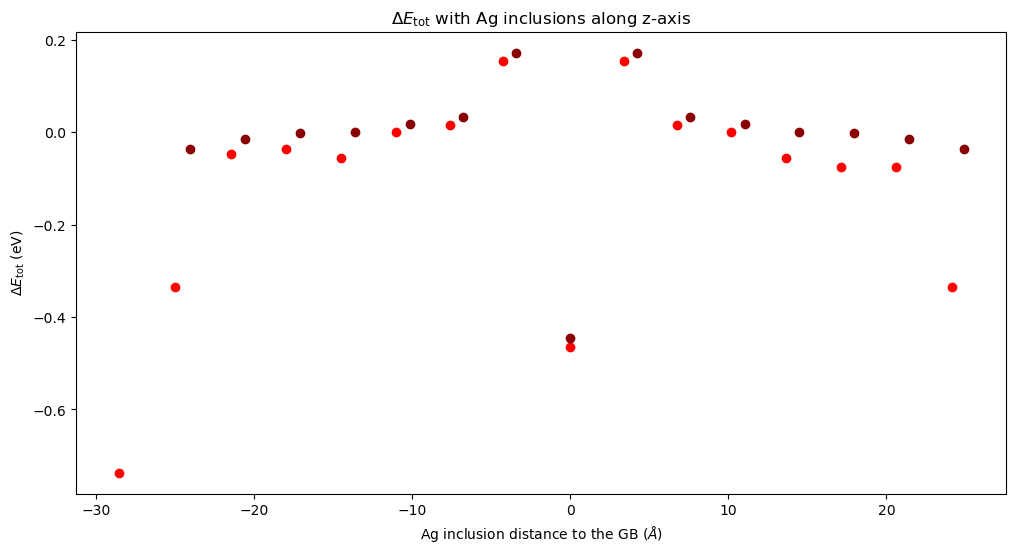

sorted_Total_Energy_Vac distance to GB plot:


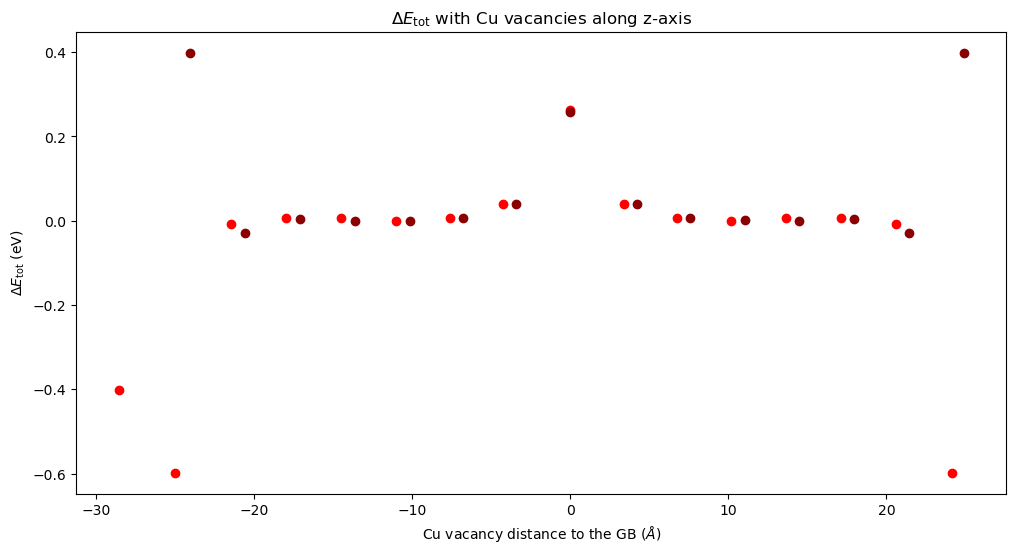

In [22]:
#Comparison Graph

'''
# Wide plot for sorted_Total_Energy_incl positions along z-axis
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(sorted_positions_017, sorted_Total_Energy_incl_deltas_017, color='red')
plt.scatter(sorted_positions_018, sorted_Total_Energy_incl_deltas_018, color='darkred')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
"""
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos_wide.png", bbox_inches='tight') 
"""
plt.savefig(f"{common_graph_folder}/017_vs_018_Ag_Segregation_Energy_deltas_pos_wide.png", bbox_inches='tight') 
plt.show()
'''

# Wide plot for sorted_Total_Energy_incl distance to GB
print("sorted_Total_Energy_incl distance to GB plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions_017, sorted_Total_Energy_incl_deltas_017, color='red')
plt.scatter(delta_z_positions_018, sorted_Total_Energy_incl_deltas_018, color='darkred')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
"""
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
"""
plt.savefig(f"{common_graph_folder}/017_vs_018_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.show()

'''
#Quick plot:
# Wide plot for sorted_Total_Energy_Vac positions along z-axis
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(sorted_positions_017, sorted_Total_Energy_Vac_deltas_017, color='red')
plt.scatter(sorted_positions_018, sorted_Total_Energy_Vac_deltas_018, color='darkred')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
"""
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos_wide.png", bbox_inches='tight') 
"""
plt.savefig(f"{common_graph_folder}/017_vs_018_Vac_Segregation_Energy_deltas_pos_wide.png", bbox_inches='tight')
plt.show()
'''

# Wide plot for sorted_Total_Energy_Vac distance to GB
print("sorted_Total_Energy_Vac distance to GB plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions_017, sorted_Total_Energy_Vac_deltas_017, color='red')
plt.scatter(delta_z_positions_018, sorted_Total_Energy_Vac_deltas_018, color='darkred')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
"""
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
"""
plt.savefig(f"{common_graph_folder}/017_vs_018_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.show()

sorted_Total_Energy_incl distance to GB plot 017_periodic red vs 018_surface darkred:


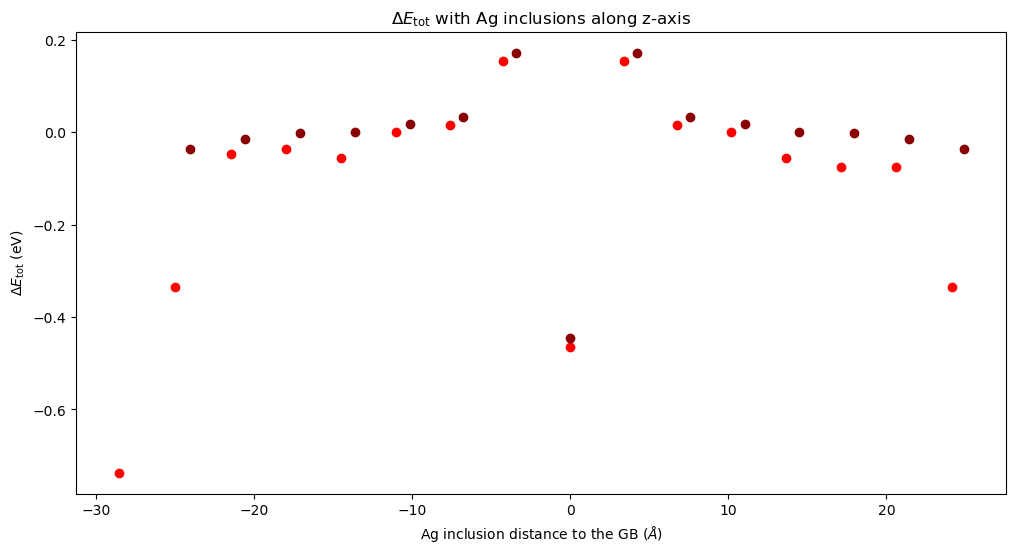

sorted_Total_Energy_Vac distance to GB plot 017_periodic red vs 018_surface darkred:


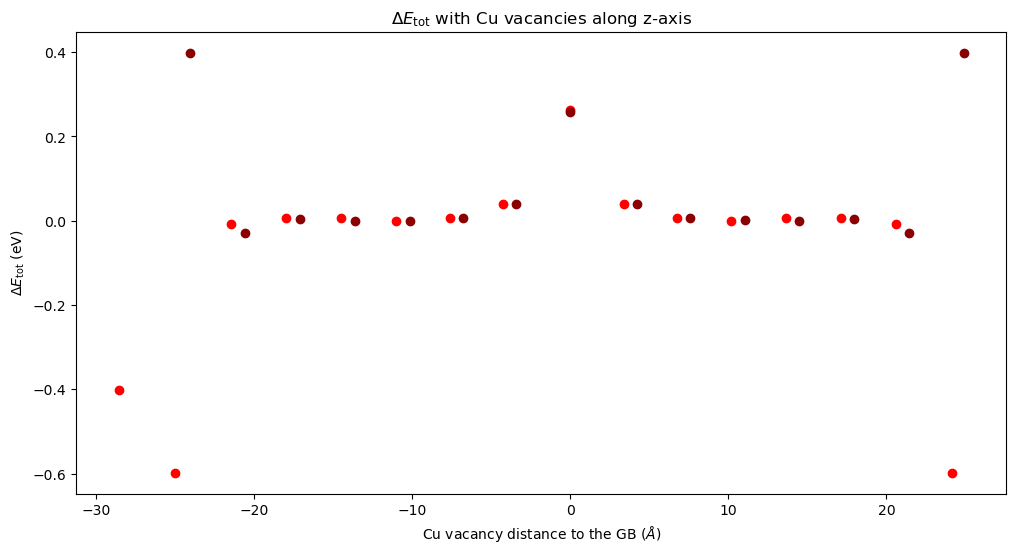

In [25]:
#Comparison Graph

# Wide plot for sorted_Total_Energy_incl distance to GB
print("sorted_Total_Energy_incl distance to GB plot 017_periodic red vs 018_surface darkred:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions_017, sorted_Total_Energy_incl_deltas_017, color='red')
plt.scatter(delta_z_positions_018, sorted_Total_Energy_incl_deltas_018, color='darkred')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
"""
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
"""
plt.savefig(f"{common_graph_folder}/017_vs_018_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.show()

# Wide plot for sorted_Total_Energy_Vac distance to GB
print("sorted_Total_Energy_Vac distance to GB plot 017_periodic red vs 018_surface darkred:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions_017, sorted_Total_Energy_Vac_deltas_017, color='red')
plt.scatter(delta_z_positions_018, sorted_Total_Energy_Vac_deltas_018, color='darkred')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
"""
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
"""
plt.savefig(f"{common_graph_folder}/017_vs_018_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.show()

In [ ]:
# To DO: Check skript:

from collections import defaultdict
from pathlib import Path
import os
import sys
import re
import copy
import matplotlib.pyplot as plt
import datetime

def analyze_lammps_energy(LAMMPS_index, Vac_ref, incl_ref, incl="Ag"):
    from ase.io import read  # Make sure ASE is available
    # Define paths
    project_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model"
    base_dir = f"{project_dir}/data/LAMMPS_Data"
    base_path = Path(base_dir)

    # Data containers
    vac_energies_dict = defaultdict(list)
    incl_energies_dict = defaultdict(list)
    Total_Energy_Vac = []
    Total_Energy_incl = []
    Total_Energy_ref = []

    # Find the folder
    folder_name = next((f.name for f in base_path.iterdir() if f.is_dir() and f.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_")), None)
    if not folder_name:
        print(f"No submission folder with index {LAMMPS_index} found.")
        sys.exit(1)
    folder_part = "_".join(folder_name.split('_')[3:])
    submission_path = base_path / f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"

    # Loop through relevant files
    for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
        parent_folder = f.parent
        grandparent_folder = parent_folder.parent

        if "BULK" in grandparent_folder.name:
            continue

        name = grandparent_folder.name
        atoms = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms.set_calculator(pot)
        energy = Corrected_Energy(atoms.get_potential_energy(), atoms)

        # Vacancy
        if match := re.search(r'(\d+)z-layers.*?Pos(\d+)-Vac\.mini\.data$', name):
            pos = match.group(2)
            vac_energies_dict[pos].append(energy)
            Total_Energy_Vac.append(energy)

        # Inclusion
        elif match := re.search(r'(\d+)z-layers.*?Pos(\d+)-' + re.escape(incl) + r'\.mini\.data$', name):
            pos = match.group(2)
            incl_energies_dict[pos].append(energy)
            Total_Energy_incl.append(energy)

        # Reference
        elif name == "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data":
            Total_Energy_ref.append(energy)

    # Sort by position
    sorted_vac = sorted(vac_energies_dict.items(), key=lambda x: int(x[0]))
    sorted_incl = sorted(incl_energies_dict.items(), key=lambda x: int(x[0]))

    sorted_positions = [pos for pos, _ in sorted_vac]
    sorted_Total_Energy_Vac = [val[0] for _, val in sorted_vac]
    sorted_Total_Energy_incl = [val[0] for _, val in sorted_incl]
    
    ref_energy = Total_Energy_ref[0]

    # Calculate relative delta energies
    Energy_Delta_incl = [e - ref_energy for e in sorted_Total_Energy_incl]
    Energy_Delta_Vac = [e - ref_energy for e in sorted_Total_Energy_Vac]
    sorted_Total_Energy_Vac_deltas = [e - Vac_ref for e in sorted_Total_Energy_Vac]
    sorted_Total_Energy_incl_deltas = [e - incl_ref for e in sorted_Total_Energy_incl]

    # Plotting
    def plot_energy_vs_position(positions, values, title, ylabel):
        plt.scatter(positions, values, color='red')
        plt.title(title)
        plt.xlabel('Position along z-axis')
        plt.ylabel(ylabel)
        plt.show()

    plot_energy_vs_position(sorted_positions, sorted_Total_Energy_Vac, 'Vacancy Total Energy', r'$\Delta E_{\mathrm{tot}}$')
    plot_energy_vs_position(sorted_positions, sorted_Total_Energy_incl, 'Inclusion Total Energy', r'$\Delta E_{\mathrm{tot}}$')
    plot_energy_vs_position(sorted_positions, sorted_Total_Energy_Vac_deltas, 'Vacancy ΔE relative to reference', r'$\Delta E$ [eV]')
    plot_energy_vs_position(sorted_positions, sorted_Total_Energy_incl_deltas, 'Inclusion ΔE relative to reference', r'$\Delta E$ [eV]')

    # Timestamp
    print("Timestamp:", datetime.datetime.now().strftime("%d-%m-%Y %H:%M"))

    # Return useful results
    return {
        "positions": sorted_positions,
        "vac_energies": sorted_Total_Energy_Vac,
        "incl_energies": sorted_Total_Energy_incl,
        "ref_energy": ref_energy,
        "delta_vac": sorted_Total_Energy_Vac_deltas,
        "delta_incl": sorted_Total_Energy_incl_deltas,
        "energy_delta_ref_vac": Energy_Delta_Vac,
        "energy_delta_ref_incl": Energy_Delta_incl
    }

result = analyze_lammps_energy("011", Vac_ref=sorted_Total_Energy_Vac[11], incl_ref=sorted_Total_Energy_incl[11])
#Expressed as a DELTA to the energy value in the middle:
# Identifying the middle element (12th entry, index 11 in 0-based indexing)
#Vac_ref = sorted_Total_Energy_Vac[11]
#incl_ref = sorted_Total_Energy_incl[11]

result = analyze_lammps_energy("017", Vac_ref=sorted_Total_Energy_Vac[11], incl_ref=sorted_Total_Energy_incl[11])
#Expressed as a DELTA to the energy value in the middle:
# Identifying the middle element (12th entry, index 11 in 0-based indexing)
#Vac_ref = sorted_Total_Energy_Vac[11]
#incl_ref = sorted_Total_Energy_incl[11]

Enter the first LAMMPS index (e.g., 001, 002, ... etc.):  017
Enter the second LAMMPS index (e.g., 001, 002, ... etc.):  018


Folder name for 017 is: LAMMPS_Submision_017_20-05-2025_11-33-57
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos15-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data
Supercell potential Energy:
-1481.9184556136129 eV
The Energy (per atom) is: -3.859162644827117 in eV per atom
Position: Pos15
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos15-Ag.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos2-Ag.mini.data
No Vac in folder name found
Confirm file: o

/tmp/ipykernel_30155/2320061279.py:187: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-1481.6891275605294 eV
The Energy (per atom) is: -3.8585654363555455 in eV per atom
Position: Pos8
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos8-Ag.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos7-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data
Supercell potential Energy:
-1481.8282300154635 eV
The Energy (per atom) is: -3.8589276823319363 in eV per atom
Position: Pos7
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z

/tmp/ipykernel_30155/2320061279.py:134: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-1479.155968061434 eV
Undivided_Energy-1479.155968061434
The Energy (per atom) is: -3.8620260262700623 in eV per atom
Position: Pos10
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos10-Vac.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos11-Vac.mini.data
Confirm file: optimize1.data
Supercell potential Energy:
-1479.1905090232458 eV
Undivided_Energy-1479.1905090232458
The Energy (per atom) is: -3.8621162115489445 in eV per atom
Position: Pos11
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Dat

/tmp/ipykernel_30155/2320061279.py:277: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)
2025-05-28 13:58:24,681 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-28 13:58:24,682 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Supercell potential Energy:
-1479.1900895715548 eV
Undivided_Energy-1479.1900895715548
The Energy (per atom) is: -3.8621151163748166 in eV per atom
Position: Pos5
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos5-Vac.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos7-Vac.mini.data
Confirm file: optimize1.data
Supercell potential Energy:
-1479.1905090232442 eV
Undivided_Energy-1479.1905090232442
The Energy (per atom) is: -3.8621162115489405 in eV per atom
Position: Pos7
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/

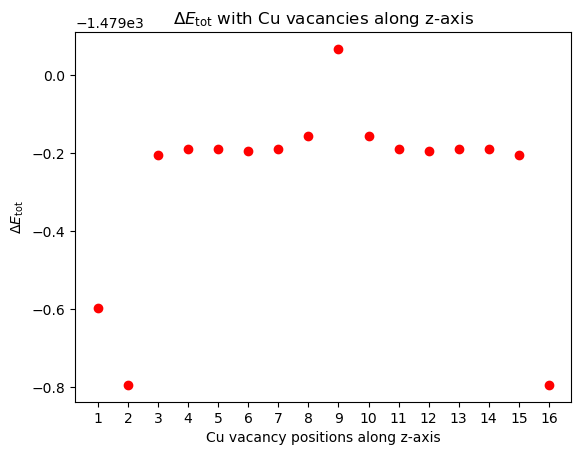

2025-05-28 13:58:24,782 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-28 13:58:24,782 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


first LAMMPS_index is:017
sorted_Total_Energy_incl plot:


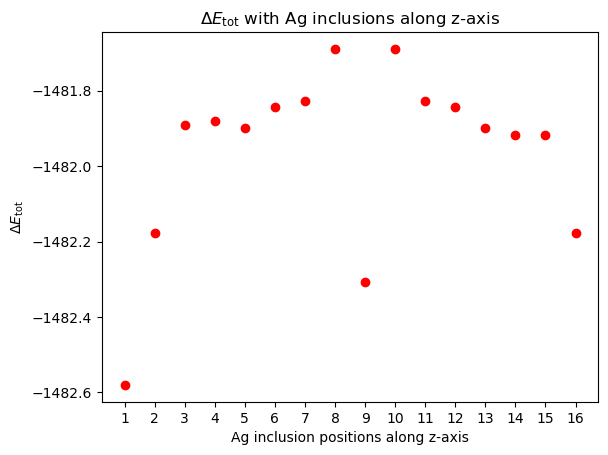

Energy_Delta_incl: [1.237557312746958, 0.9778847894087903, 1.4668853658304215, 1.3277829108963033, 1.2572724519259282, 1.2661274019476423, 0.5757051764810512, 1.4668853658304215, 1.3277829108981223, 1.3126044950456617, 1.2572724519261556, 1.2375023380643597, 0.977884789406744, 0.8481395449257434, 1.3126044950454343, 1.2768030568113318];
16 Energy_Delta_incl list entrys
Energy_Delta_Vac: [4.00004486492594, 3.9655039031140404, 3.966206299372743, 3.3618784716443315, 3.9520712021273994, 3.9520712021294457, 4.000044864925258, 4.222504146298434, 3.960006660190402, 3.5577343658280824, 3.960006660191766, 3.9659233548047723, 3.361878471645241, 3.966206299372061, 3.9659233548049997, 3.965503903115632];
16 Energy_Delta_Vac list entrys


Atoms(symbols='Cu96Ga96Se192', pbc=True, cell=[8.006053584728107, 19.623315244560512, 56.23681114532088], id=..., masses=..., momenta=..., type=...)
Center of the atoms: [ 4.00302679  9.80199987 27.5844096 ]
Closest Cu atom is at index 81 with coordinates: [ 5.442

/tmp/ipykernel_30155/2320061279.py:666: DeprecationWarning: Please use atoms.calc = calc
  atoms2.set_calculator(pot)


Supercell potential Energy:
-1447.2831529183459 eV
The Energy (per atom) is: -3.8491573215913455 in eV per atom
Position_2: Pos10
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_018_20-05-2025_11-37-14/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_20A-VACUUMS_Pos10-Ag.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_018_20-05-2025_11-37-14/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_20A-VACUUMS_Pos11-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data
Supercell potential Energy:
-1447.29835764561 eV
The Energy (per atom) is: -3.849197759695771 in eV per atom
Position_2: Pos11
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_018_20-05-2025_11-37-14/31_Submited_mini_data_folders/0_

/tmp/ipykernel_30155/2320061279.py:613: DeprecationWarning: Please use atoms.calc = calc
  atoms2.set_calculator(pot)


Supercell potential Energy:
-1444.6815120031326 eV
Undivided_Energy-1444.6815120031326
The Energy (per atom) is: -3.8524840320083538 in eV per atom
Position: Pos14
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_018_20-05-2025_11-37-14/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_20A-VACUUMS_Pos14-Vac.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_018_20-05-2025_11-37-14/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_20A-VACUUMS_Pos2-Vac.mini.data
Confirm file: optimize1.data
Supercell potential Energy:
-1444.681512003134 eV
Undivided_Energy-1444.681512003134
The Energy (per atom) is: -3.8524840320083573 in eV per atom
Position: Pos2
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE

/tmp/ipykernel_30155/2320061279.py:759: DeprecationWarning: Please use atoms.calc = calc
  atoms2.set_calculator(pot)
2025-05-28 13:58:26,689 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-28 13:58:26,690 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Supercell potential Energy:
-1444.395594536647 eV
Undivided_Energy-1444.395594536647
The Energy (per atom) is: -3.8517215854310587 in eV per atom
Position: Pos8
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_018_20-05-2025_11-37-14/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_20A-VACUUMS_Pos8-Vac.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_018_20-05-2025_11-37-14/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_20A-VACUUMS.mini.data
No Vac in folder name found
No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_018_20-05-2025_11-37-14/31_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_20A-VACUUMS.mini.data

############################

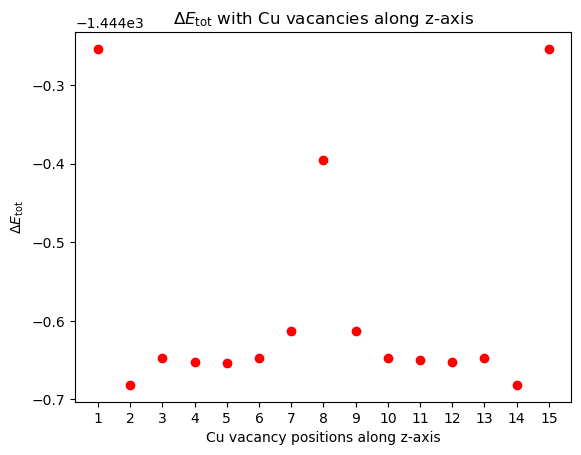

2025-05-28 13:58:26,788 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-28 13:58:26,789 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


second LAMMPS_index is:018
sorted_Total_Energy_incl_2 plot:


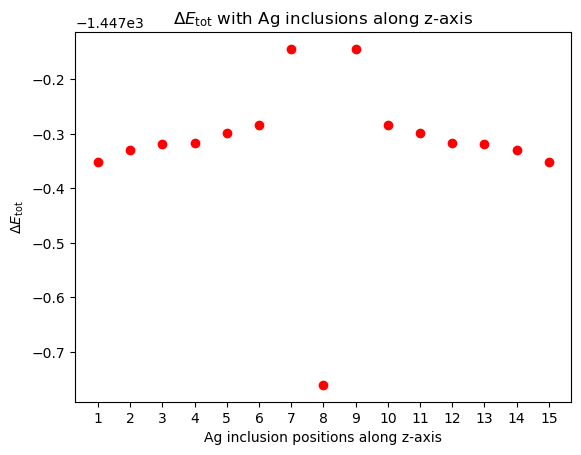

Total_Energy_ref_2: [-1448.6123273731023]
Energy_Delta_incl_2: [1.2597528118324135, 1.3291744547564122, 1.3139697274923492, 1.281892325773697, 1.293568972054345, 1.2960363731622238, 1.2935689720570736, 1.2818923257739243, 1.2597528118305945, 1.2960363731613143, 1.4680509244858513, 0.8516895469122119, 1.3139697274937134, 1.3291744547566395, 1.4680509244858513];
15 Energy_Delta_incl_2 list entrys
Energy_Delta_Vac_2: [4.3584849788317115, 3.9656057614090514, 3.9308153699696504, 3.930815369968286, 3.9649403919888755, 4.3584849788317115, 3.964940391987966, 3.959691464084244, 3.962110683156652, 3.959691464084017, 3.999590379692563, 3.9592092028717616, 3.965605761409279, 3.9995903796932453, 4.216732836455321];
15 Energy_Delta_Vac_2 list entrys


Atoms(symbols='Cu94Ga94Se188', pbc=True, cell=[8.006053584728107, 19.623315244560512, 95.29105450340896], id=..., masses=..., momenta=..., type=...)
Center of the atoms: [ 4.02431949  9.80251227 48.16177399]
Closest Cu atom is at index 88 with coordina

Check with visualisation? y/N:  


Skipping visualistion.

index list: [55, 54, 50, 39, 25, 12, 0, 88, 3, 20, 32, 35, 57, 72, 74];
15 distance_to_center_index_list list entrys
sorted_z_positions_2:
 [23.68064431306624, 27.162111046915616, 30.64046798305273, 34.112300992432694, 37.56789678703631, 40.97231386954226, 44.30665565286225, 47.72654423313529, 51.97951414992781, 55.3059786559881, 58.75607226016428, 62.216957445252824, 65.68436727174844, 69.16247616506777, 72.64492039787503];
15 sorted_z_positions_2 list entrys
Closest Cu atom to center is at index 88 with coordinates: [ 5.44089447 10.99335025 47.72654423]
center_z_position is 47.72654423313529

delta_z_positions_2:
 [-24.045899920069054, -20.564433186219677, -17.086076250082563, -13.6142432407026, -10.158647446098982, -6.754230363593031, -3.419888580273046, 0.0, 4.252969916792516, 7.579434422852806, 11.029528027028988, 14.49041321211753, 17.95782303861315, 21.43593193193248, 24.918376164739733];
15 delta_z_positions_2 list entrys


Plot collection:
first LAMMPS_

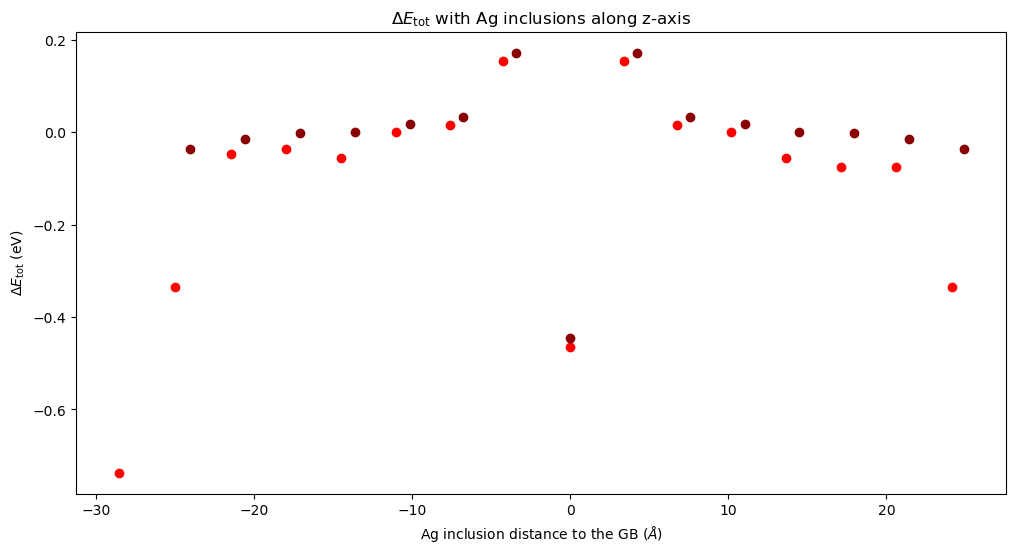

sorted_Total_Energy_Vac distance to GB plot 017_periodic red vs 018_surface_1var darkred:


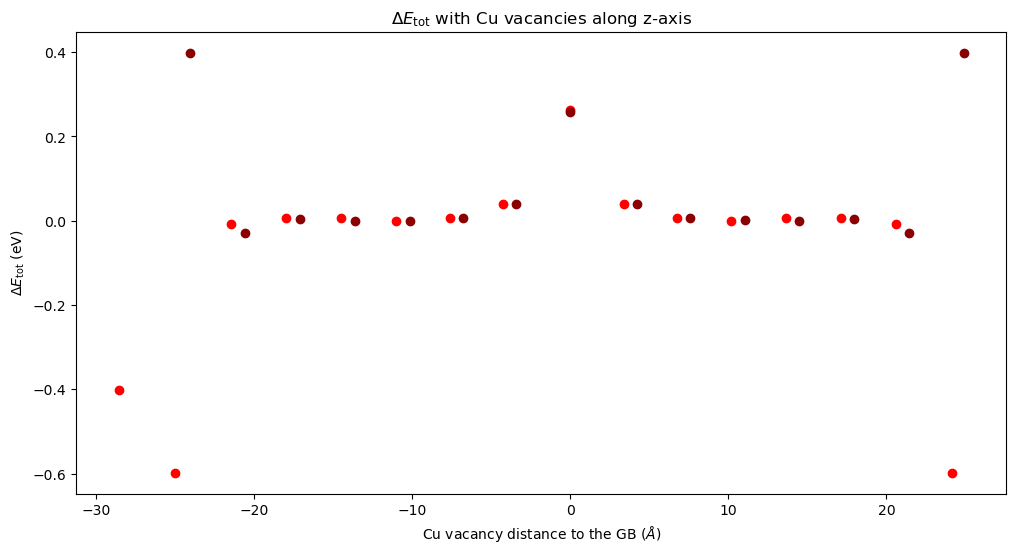

017vs018_part1_DONE

Timestamp:
28-05-2025 13:58


In [43]:
#To do FIX DUAL READOUT

from collections import defaultdict
import re


# Ask the user for the LAMMPS index
#LAMMPS_index = '011'
LAMMPS_index = input("Enter the first LAMMPS index (e.g., 001, 002, ... etc.): ")
LAMMPS_index_2 = input("Enter the second LAMMPS index (e.g., 001, 002, ... etc.): ")
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#Section 1 read out energies from incl/Vac <----------------------------------------DONE NEEDS POLISH

incl = "Ag"

# Define the base directory
project_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model"
base_dir = f"{project_dir}/data/LAMMPS_Data"

# Clear preexisting variables
layer = []
layers = []
e_pot_Vac = []
Total_Energy_Vac = []
Total_Energy_Vac_per_atom = []
e_pot_incl = []
Total_Energy_incl = []
Total_Energy_incl_per_atom = []
e_pot_ref = []
Total_Energy_ref = []
Total_Energy_ref_per_atom = []
n_reps = []

layer_2 = []
layers_2 = []
e_pot_Vac_2 = []
Total_Energy_Vac_2 = []
Total_Energy_Vac_per_atom_2 = []
e_pot_incl_2 = []
Total_Energy_incl_2 = []
Total_Energy_incl_per_atom_2 = []
e_pot_ref_2 = []
Total_Energy_ref_2 = []
Total_Energy_ref_per_atom_2 = []
n_reps_2 = []
"""
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []
"""

# List all directories in the base directory
base_path = Path(base_dir)


# Initialize dictionaries to store energies for both Vac and incl
vac_energies_dict = defaultdict(list)
incl_energies_dict = defaultdict(list)

vac_energies_dict_2 = defaultdict(list)
incl_energies_dict_2 = defaultdict(list)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

"""
# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_formation_energies_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)
"""

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue # Skip BULK files
    else:
        #TO DO split this one into 3 parts

        #Read out Vacancy versions:
        
        # If the folder does not contain "BULK", process the file
        print(Path(grandparent_folder))
        data_folder = grandparent_folder

        matchVac = re.search(r'(\d+)z-layers.*?Pos(\d+)-Vac\.mini\.data$', data_folder.name)
        
        if matchVac:
            #old:
            #layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_Vac_str)
            position = matchVac.group(2)  # Extract the position (e.g., Pos14)

            print(f"Confirm file: {f.name}")

            # Read the atoms data
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_Vac_uncorrected = atoms1.get_potential_energy()
            e_pot_Vac = Corrected_Energy(e_pot_Vac_uncorrected, atoms1)
            # Add to the vac_energies dictionary
            vac_energies_dict[position].append(e_pot_Vac)
            print("Supercell potential Energy:")
            print(e_pot_Vac, "eV")
            Total_Energy_Vac.append(e_pot_Vac)
        
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_Vac
            print(f"Undivided_Energy{Undivided_Energy}")
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_Vac_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print("Vac DONE\n")
            
        else:
            print(f"No Vac in folder name found")
            #continue  # Skip if no layer count is found
        
        #-----------------------------------------------------------------------------------------

        #old
        #matchincl = re.search(r'(\d+)z-layers.*?Pos\d+-Ag\.mini\.data$', data_folder.name)
        matchincl = re.search(r'(\d+)z-layers.*?Pos(\d+)-Ag\.mini\.data$', data_folder.name)

        #Read out incl versions:
        
        #replace Ag with incl  
        #new approach: # <------------------------------------------------------------------------------- OPEN
        #pattern = re.compile(r'(\d+)z-layers.*?Pos\d+-' + re.escape(incl) + r'\.mini\.data$')

        # Test filenames
        #filename1 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Ag.mini.data"
        #filename2 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Vac.mini.data"

        #print(bool(pattern.search(filename1)))  # ✅ True if incl = "Ag"
        #print(bool(pattern.search(filename2)))  # ❌ False if incl = "Ag"
        
        if matchincl:
            layers_incl_str = matchincl.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_incl_str)
            position = matchincl.group(2)  # Extract the position (e.g., Pos14)
            
            print(f"Confirm file: {f.name}")

            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_incl_uncorrected = atoms1.get_potential_energy()
            e_pot_incl = Corrected_Energy(e_pot_incl_uncorrected, atoms1)
            # Add to the incl_energies dictionary
            incl_energies_dict[position].append(e_pot_incl)

            print("Supercell potential Energy:")
            print(e_pot_incl, "eV")
            Total_Energy_incl.append(e_pot_incl)
            
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_incl
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_incl_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print(f"{incl} DONE\n")
            
        else:
            print(f"No {incl} in folder name found")
            #continue  # Skip if no layer count is found

        #---------------------------------------------------------------------------------------

        #OPEN read in reference Energy OPEN <-------------------------------------

        #look into If the folder does not contain "BULK" bzw "incl" or Vac, process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        # Replace with the actual path or folder object if needed
        data_folder_name = data_folder.name  # Assumes data_folder is a pathlib.Path or similar object

        
        # Exact match with folder name
        """
        if data_folder_name == "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data":
        #if data_folder_name == "0_print_steps_CuGaSe2_GB_S9_12z-layers.mini.data":
            # Optional: extract the '36z' value if needed (not currently used)
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # or handle the error
                
        """

        '''
        # Match ONLY files like: 0_anything_CuGaSe2_..._z-layers_20A-VACUUMS.mini.data
        # and explicitly exclude ones that continue with "_pos" or other suffixes before .mini.data
        match_ref = re.match(r"0_.*CuGaSe2.*z-layers_20A-VACUUMS\.mini\.data$", data_folder_name)

        if match_ref:
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # Optional: fallback or warning
        '''
        
        # Match files that:
        # - start with 0_
        # - contain CuGaSe2
        # - end with .mini.data
        # - but do NOT contain "-Ag", "-Vac", or "Pos<digits>" anywhere
        is_reference_file = (
            data_folder_name.startswith("0_")
            and "CuGaSe2" in data_folder_name
            and data_folder_name.endswith(".mini.data")
            and not re.search(r"(Pos\d+|-Ag|-Vac)", data_folder_name)
        )
        
        if is_reference_file:
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # Or handle this more explicitly if needed
      
        
            print(f"\n##############################################################################################################################")
            print(f"Confirm folder: {data_folder_name}")

            
            GB = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1: 31, 2: 29, 3: 47, 4: 34})
            atoms1.set_calculator(pot)

            n_reps.append(len(atoms1))

            e_pot_ref_uncorrected = atoms1.get_potential_energy()
            e_pot_ref = Corrected_Energy(e_pot_ref_uncorrected, atoms1)

            print("Supercell potential Energy:")
            print(e_pot_ref, "eV")
            Total_Energy_ref.append(e_pot_ref)

            Undivided_Energy = e_pot_ref
            Divided_Energy = Undivided_Energy / len(atoms1)
            Total_Energy_ref_per_atom.append(Divided_Energy)
        
            print(f"The Energy (per atom) is: {Divided_Energy} eV per atom")

            if layers:
                print(f"{layers} layers done\n")

            print("ref DONE")
            print(f"##############################################################################################################################\n")
        else:
            print("No Ref in folder name found")
        

        #-----------------------------------------------------------------------------------------
        #create dict (pos|energy)


        #-----------------------------------------------------------------------------------------


print("\n")
print(f"first LAMMPS_index is:{LAMMPS_index}")
print(f"vac_energies_dict:\n{vac_energies_dict}\n") 
print(f"incl_energies_dict:\n{incl_energies_dict}\n") 

sorted_vac_energies_dict = sorted(vac_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"
sorted_incl_energies_dict = sorted(incl_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"

sorted_positions = []
sorted_Total_Energy_Vac = []
sorted_Total_Energy_incl = []

# Print out the sorted energies with their positions
print(f"first LAMMPS_index is:{LAMMPS_index}")
print("\nVacancy Energies (Sorted by Position):")
for pos, energies in sorted_vac_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_Vac.append(energies[0])  #Extract the energy float value
    sorted_positions.append(pos)  #Extract the position int value

print("\nInclination Energies (Sorted by Position):")
for pos, energies in sorted_incl_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_incl.append(energies[0]) #Extract the float value

print(f"\nsorted_vac_energies_dict:\n{sorted_vac_energies_dict}\n") 
print(f"sorted_incl_energies_dict:\n{sorted_incl_energies_dict}\n") 

print("\n")
print("For comparison: old unsorted:")
print(f"Total_Energy_Vac:{Total_Energy_Vac};\n{len(Total_Energy_Vac)} Total_Energy_Vac list entrys")
print(f"Total_Energy_incl:{Total_Energy_incl};\n{len(Total_Energy_incl)} Total_Energy_incl list entrys")


print("\n")
print(f"sorted_positions:{sorted_positions};\n{len(sorted_positions)} sorted_positions list entrys")
print(f"sorted_Total_Energy_Vac:{sorted_Total_Energy_Vac};\n{len(sorted_Total_Energy_Vac)} sorted_Total_Energy_Vac list entrys")
print(f"sorted_Total_Energy_incl:{sorted_Total_Energy_incl};\n{len(sorted_Total_Energy_incl)} sorted_Total_Energy_incl list entrys")
print(f"Total_Energy_ref:{Total_Energy_ref};\n{len(Total_Energy_ref)} Total_Energy_ref list entrys")
print("\n")


#read out Total Energy for all 24 pos Vac | DONE
#24 values

#read out Total Energy for all 24 pos Ag/Cu? | DONE
#24 values

#read out Total Energy for reference | DONE
#1 value


#Quick plot:
print(f"first LAMMPS_index is:{LAMMPS_index}")
print("sorted_Total_Energy_Vac plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print(f"first LAMMPS_index is:{LAMMPS_index}")
print("sorted_Total_Energy_incl plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()


# Step 3:  Calculate Enegy Delta:

# Assuming Total_Energy_ref has only one value
ref_energy = Total_Energy_ref[0]

# Calculate delta lists
Energy_Delta_incl = [energy - ref_energy for energy in Total_Energy_incl]
Energy_Delta_Vac = [energy - ref_energy for energy in Total_Energy_Vac]

# Optional: print for confirmation
print(f"Energy_Delta_incl: {Energy_Delta_incl};\n{len(Energy_Delta_incl)} Energy_Delta_incl list entrys")
print(f"Energy_Delta_Vac: {Energy_Delta_Vac};\n{len(Energy_Delta_Vac)} Energy_Delta_Vac list entrys")
print("\n")

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

#Section 2 get distance of position <---------------------------------------------DONE


#find Ag pre for all 24 pos
#read files:
#create list:
incl_pos_pre = []

#find Vac pre from Ag pre (should be the same)
#read files:
#create list:
vac_pos_pre = []

#find Ag post for all 24 pos
#read files:
#create list:
incl_pos_post = []

#find Vac post for all 24 pos (is it the same?)
#read files:
#create list:
vac_pos_post = []


#Step 1: Find positions:

# Step 8.0 index Cu center to border:
#print("edit 1")
print(GB)
#reminder no screen elemnts outside of the office possible
#GB.edit()


######################################################################################################################################
# Problem: Shallow Copy: GB_revert = GB creates a shallow copy of GB. 
# This means both GB_revert and GB reference the same object (atoms list).
# Solution:
# Create a deep copy of GB
GB_revert = copy.deepcopy(GB)  # Make sure GB_revert is an independent copy
"""
print(GB_revert)
GB.edit()
"""

# Step 8.1 find center
center = find_center_of_atoms(GB)

# Step 8.2 find Cu pos closest to center
closest_atom_index, closest_atom_position = find_closest_atom_to_center(GB, center, "Cu")
#print(f"TEST: Closest Cu atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")

# Step 8.2.1 confirm Cu (replace with Bi)
ask_to_check_visuals = "skip"

GB_test1 = swap_atoms(GB, closest_atom_index, "Bi")
print(f"ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)")
ask_user_for_visuals(GB_test1, ask_to_check_visuals)

# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state

print(f"index center atom: {closest_atom_index}")

"""
print("edit 2")
print(GB_revert)
print(GB)
GB.edit()

print("\n\nExecution is being cancelled 1. Breaking the script.")
sys.exit()  # Exit the script immediately
"""


#Step 8.3 find Cu pos > center (in x or y tolerance room? 1 [x] strict \ \ \ \ pattern should not matter --> periodicity)
#and create index list: distance_to_center_index_list 
"""
#distance_to_center_index_list = [closest_atom_index]
#distance_to_center_index_list.append(next_atom_index)
#distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
"""

#Step 1.4 create index list: distance_to_center_index_list 
distance_to_center_index_list = []
distance_to_center_index_list_1 = []
distance_to_center_index_list_2 = []

#XHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXH

#def get_atoms_with_smaller_z(atoms, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance=0.1):
distance_to_center_index_list_1 = get_atoms_with_smaller_z(GB, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance= 0.7, x_tolerance = 3) 
distance_to_center_index_list_1.reverse()
print(f"distance_to_center_index_list_part1 = {distance_to_center_index_list_1}")

closest_atom_index_list = [closest_atom_index]
print(f"closest_atom_index_list (to center) = {closest_atom_index_list}")

distance_to_center_index_list_2 = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.7, x_tolerance = 3)    
print(f"distance_to_center_index_list_part2 = {distance_to_center_index_list_2}")

distance_to_center_index_list = distance_to_center_index_list_1 + closest_atom_index_list + distance_to_center_index_list_2
print(f"distance_to_center_index_list = {distance_to_center_index_list}")


#distance_to_center_index_list = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.5)    
#print(f"distance_to_center_index_list = {distance_to_center_index_list}")


#XHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXH




#Step 8.4 test version --> untill surface is hit (save atoms object as GB_incl_long)
ask_to_check_visuals = "skip"
#ask_to_check_visuals = "ask"
GB_test2 = swap_atoms(GB, distance_to_center_index_list, "Bi")
#view(GB_test2)
print(f"ask_user_for_visuals for Step: 8.4 test version --> untill surface is hit")
ask_user_for_visuals(GB_test2, ask_to_check_visuals)
# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state
#print("edit 3")
#GB.edit()

#print(f"index list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")
print(f"\nindex list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")

# Extract z-positions of atoms at the given indices
z_positions = [GB[i].position[2] for i in distance_to_center_index_list]

# Sort the z-positions from small to large
sorted_z_positions = sorted(z_positions)

# Print the sorted z-positions
print(f"sorted_z_positions:\n {sorted_z_positions};\n{len(sorted_z_positions)} sorted_z_positions list entrys")
print(f"Closest Cu atom to center is at index {closest_atom_index} with coordinates: {closest_atom_position}")
print(f"center_z_position is {closest_atom_position[2]}")
#Closest Cu atom is at index 271 with coordinates: [  5.44242076  10.91675073 103.01715074]


#Step 2: get positon Delta (rel to center):
#calculate delta: [Pos pre]-[Pos post]??? (nessecary?) --> NO! Distance to Center Atom!!! (get center from function in ASE)!
#_pre or _post static relaxation pos? ==> select and print result Pre relax /post static / post MD

# Subtract the center z position from each sorted z position to get the delta (difference)
delta_z_positions = [z - closest_atom_position[2] for z in sorted_z_positions]
print(f"\ndelta_z_positions:\n {delta_z_positions};\n{len(delta_z_positions)} delta_z_positions list entrys")

print(f"##############################################################################################################################\n")
print(f"First LAMMPS_index:{LAMMPS_index} DONE.\n")
print(f"##############################################################################################################################\n")
        
#WMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWM
#WMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWM      
#WMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWM

# Step 3: Find the folder name matching the pattern for the second LAMMPS_Submision:

folder_name_2 = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index_2}_"):
        folder_name_2 = folder.name
        break
print(f"Folder name for {LAMMPS_index_2} is: {folder_name_2}")

if folder_name_2:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part_2 = "_".join(folder_name_2.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission_2 = f"LAMMPS_Submision_{LAMMPS_index_2}_{folder_part_2}"
    # Construct the full path
    submission_path_2 = base_path / LAMMPS_Submission_2
else:
    print(f"No submission folder with index {LAMMPS_index_2} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

"""
# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_formation_energies_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)
"""

# Step 4:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path_2.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder_2 = f.parent
    grandparent_folder_2 = parent_folder_2.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder_2.name:
        continue # Skip BULK files
    else:
        #TO DO split this one into 3 parts

        #Read out Vacancy versions:
        
        # If the folder does not contain "BULK", process the file
        print(Path(grandparent_folder_2))
        data_folder_2 = grandparent_folder_2

        matchVac_2 = re.search(r'(\d+)z-layers.*?Pos(\d+)-Vac\.mini\.data$', data_folder_2.name)
        
        if matchVac_2:
            #old:
            #layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers_Vac_str_2 = matchVac_2.group(1)  # Extract the z-layer value (e.g., 12)
            layers_2 = int(layers_Vac_str_2)
            position_2 = matchVac_2.group(2)  # Extract the position (e.g., Pos14)

            print(f"Confirm file: {f.name}")

            # Read the atoms data
            atoms2 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms2.set_calculator(pot)
            n_reps.append(len(atoms2))
            e_pot_Vac_uncorrected_2 = atoms2.get_potential_energy()
            e_pot_Vac_2 = Corrected_Energy(e_pot_Vac_uncorrected_2, atoms2)
            # Add to the vac_energies dictionary
            vac_energies_dict_2[position_2].append(e_pot_Vac_2)
            print("Supercell potential Energy:")
            print(e_pot_Vac_2, "eV")
            Total_Energy_Vac_2.append(e_pot_Vac_2)
        
            #divide by atom count (needed?)
            Undivided_Energy_2 = e_pot_Vac_2
            print(f"Undivided_Energy{Undivided_Energy_2}")
            Divided_Energy_2 = Undivided_Energy_2/len(atoms2)
            Total_Energy_Vac_per_atom_2.append(Divided_Energy_2)
            print(f"The Energy (per atom) is: {Divided_Energy_2} in eV per atom")
            print(f"Position: Pos{position_2}")
            if layer_2:
                print(f"{layer_2}layers_done\n")
                layers_2.append(layer_2)
            print("Vac DONE\n")
            
        else:
            print(f"No Vac in folder name found")
            #continue  # Skip if no layer count is found
        
        #-----------------------------------------------------------------------------------------

        #old
        #matchincl = re.search(r'(\d+)z-layers.*?Pos\d+-Ag\.mini\.data$', data_folder.name)
        matchincl_2 = re.search(r'(\d+)z-layers.*?Pos(\d+)-Ag\.mini\.data$', data_folder_2.name)

        #Read out incl versions:
        
        #replace Ag with incl  
        #new approach: # <------------------------------------------------------------------------------- OPEN
        #pattern = re.compile(r'(\d+)z-layers.*?Pos\d+-' + re.escape(incl) + r'\.mini\.data$')

        # Test filenames
        #filename1 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Ag.mini.data"
        #filename2 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Vac.mini.data"

        #print(bool(pattern.search(filename1)))  # ✅ True if incl = "Ag"
        #print(bool(pattern.search(filename2)))  # ❌ False if incl = "Ag"
        
        if matchincl_2:
            layers_incl_str_2 = matchincl_2.group(1)  # Extract the z-layer value (e.g., 12)
            layers_2 = int(layers_incl_str_2)
            position_2 = matchincl_2.group(2)  # Extract the position (e.g., Pos14)
            
            print(f"Confirm file: {f.name}")

            atoms2 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms2.set_calculator(pot)
            n_reps.append(len(atoms2))
            e_pot_incl_uncorrected_2 = atoms2.get_potential_energy()
            e_pot_incl_2 = Corrected_Energy(e_pot_incl_uncorrected_2, atoms2)
            # Add to the incl_energies dictionary
            incl_energies_dict_2[position_2].append(e_pot_incl_2)

            print("Supercell potential Energy:")
            print(e_pot_incl_2, "eV")
            Total_Energy_incl_2.append(e_pot_incl_2)
            
            #divide by atom count (needed?)
            Undivided_Energy_2 = e_pot_incl_2
            Divided_Energy_2 = Undivided_Energy_2/len(atoms2)
            Total_Energy_incl_per_atom_2.append(Divided_Energy_2)
            print(f"The Energy (per atom) is: {Divided_Energy_2} in eV per atom")
            print(f"Position_2: Pos{position_2}")
            if layer_2:
                print(f"{layer_2}layers_done\n")
                layers_2.append(layer_2)
            print(f"{incl} DONE\n")
            
        else:
            print(f"No {incl} in folder name found")
            #continue  # Skip if no layer count is found

        #---------------------------------------------------------------------------------------

        #OPEN read in reference Energy OPEN <-------------------------------------

        #look into If the folder does not contain "BULK" bzw "incl" or Vac, process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder_2))
        data_folder_2 = grandparent_folder_2
        # Replace with the actual path or folder object if needed
        data_folder_name_2 = data_folder_2.name  # Assumes data_folder is a pathlib.Path or similar object

        
        # Exact match with folder name
        """
        if data_folder_name == "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data":
        #if data_folder_name == "0_print_steps_CuGaSe2_GB_S9_12z-layers.mini.data":
            # Optional: extract the '36z' value if needed (not currently used)
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # or handle the error
                
        """

        '''
        # Match ONLY files like: 0_anything_CuGaSe2_..._z-layers_20A-VACUUMS.mini.data
        # and explicitly exclude ones that continue with "_pos" or other suffixes before .mini.data
        match_ref = re.match(r"0_.*CuGaSe2.*z-layers_20A-VACUUMS\.mini\.data$", data_folder_name)

        if match_ref:
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # Optional: fallback or warning
        '''
        
        # Match files that:
        # - start with 0_
        # - contain CuGaSe2
        # - end with .mini.data
        # - but do NOT contain "-Ag", "-Vac", or "Pos<digits>" anywhere
        is_reference_file_2 = (
            data_folder_name_2.startswith("0_")
            and "CuGaSe2" in data_folder_name_2
            and data_folder_name_2.endswith(".mini.data")
            and not re.search(r"(Pos\d+|-Ag|-Vac)", data_folder_name_2)
        )
        
        if is_reference_file_2:
            match_layers_2 = re.search(r'(\d+)z-layers', data_folder_name_2)
            if match_layers_2:
                layers_2 = int(match_layers_2.group(1))
            else:
                layers_2 = None  # Or handle this more explicitly if needed
      
        
            print(f"\n##############################################################################################################################")
            print(f"Confirm folder: {data_folder_name_2}")

            
            GB_2 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            print(f"GB_2 set for {LAMMPS_index_2}")
            print(GB_2)
            #view(GB_2)
            atoms2 = read(f, format='lammps-data', style='atomic', Z_of_type={1: 31, 2: 29, 3: 47, 4: 34})
            atoms2.set_calculator(pot)

            n_reps.append(len(atoms2))

            e_pot_ref_uncorrected_2 = atoms2.get_potential_energy()
            e_pot_ref_2 = Corrected_Energy(e_pot_ref_uncorrected_2, atoms2)

            print("Supercell potential Energy:")
            print(e_pot_ref_2, "eV")
            Total_Energy_ref_2.append(e_pot_ref_2)

            Undivided_Energy_2 = e_pot_ref_2
            Divided_Energy_2 = Undivided_Energy_2 / len(atoms2)
            Total_Energy_ref_per_atom_2.append(Divided_Energy_2)
        
            print(f"The Energy (per atom) is: {Divided_Energy_2} eV per atom")

            if layers_2:
                print(f"{layers_2} layers done\n")

            print("ref DONE")
            print(f"##############################################################################################################################\n")
        else:
            print("No Ref in folder name found")
        

        #-----------------------------------------------------------------------------------------
        #create dict (pos|energy)


        #-----------------------------------------------------------------------------------------


print("\n")
print(f"second LAMMPS_index is:{LAMMPS_index_2}")
print(f"vac_energies_dict_2:\n{vac_energies_dict_2}\n") 
print(f"incl_energies_dict_2:\n{incl_energies_dict_2}\n") 

sorted_vac_energies_dict_2 = sorted(vac_energies_dict_2.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"
sorted_incl_energies_dict_2 = sorted(incl_energies_dict_2.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"

sorted_positions_2 = []
sorted_Total_Energy_Vac_2 = []
sorted_Total_Energy_incl_2 = []

# Print out the sorted energies with their positions
print(f"second LAMMPS_index is:{LAMMPS_index_2}")
print("\nVacancy Energies (Sorted by Position):")
for pos_2, energies_2 in sorted_vac_energies_dict_2:
    print(f"Pos: {pos_2}: {energies_2}")
    sorted_Total_Energy_Vac_2.append(energies_2[0])  #Extract the energy float value
    sorted_positions_2.append(pos_2)  #Extract the position int value

print("\nInclination Energies (Sorted by Position):")
for pos_2, energies_2 in sorted_incl_energies_dict_2:
    print(f"Pos: {pos_2}: {energies_2}")
    sorted_Total_Energy_incl_2.append(energies_2[0]) #Extract the float value

print(f"\nsorted_vac_energies_dict_2:\n{sorted_vac_energies_dict_2}\n") 
print(f"sorted_incl_energies_dict_2:\n{sorted_incl_energies_dict_2}\n") 

print("\n")
print("For comparison: old unsorted:")
print(f"Total_Energy_Vac_2:{Total_Energy_Vac_2};\n{len(Total_Energy_Vac_2)} Total_Energy_Vac_2 list entrys")
print(f"Total_Energy_incl_2:{Total_Energy_incl_2};\n{len(Total_Energy_incl_2)} Total_Energy_incl_2 list entrys")


print("\n")
print(f"sorted_positions_2:{sorted_positions_2};\n{len(sorted_positions_2)} sorted_positions_2 list entrys")
print(f"sorted_Total_Energy_Vac_2:{sorted_Total_Energy_Vac_2};\n{len(sorted_Total_Energy_Vac_2)} sorted_Total_Energy_Vac_2 list entrys")
print(f"sorted_Total_Energy_incl_2:{sorted_Total_Energy_incl_2};\n{len(sorted_Total_Energy_incl_2)} sorted_Total_Energy_incl_2 list entrys")
print(f"Total_Energy_ref_2:{Total_Energy_ref_2};\n{len(Total_Energy_ref_2)} Total_Energy_ref_2 list entrys")
print("\n")


#read out Total Energy for all 24 pos Vac | DONE
#24 values

#read out Total Energy for all 24 pos Ag/Cu? | DONE
#24 values

#read out Total Energy for reference | DONE
#1 value


#Quick plot:
print(f"second LAMMPS_index is:{LAMMPS_index_2}")
print("sorted_Total_Energy_Vac_2 plot:")
plt.scatter(sorted_positions_2, sorted_Total_Energy_Vac_2, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print(f"second LAMMPS_index is:{LAMMPS_index_2}")
print("sorted_Total_Energy_incl_2 plot:")
plt.scatter(sorted_positions_2, sorted_Total_Energy_incl_2, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()


# Step 3:  Calculate Enegy Delta:

# Assuming Total_Energy_ref has only one value
"""
print(f"Total_Energy_ref: {Total_Energy_ref}")
ref_energy = Total_Energy_ref[0]
"""

print(f"Total_Energy_ref_2: {Total_Energy_ref_2}")
ref_energy_2 = Total_Energy_ref_2[0]

# Calculate delta lists
"""
Energy_Delta_incl = [energy - ref_energy for energy in Total_Energy_incl]
Energy_Delta_Vac = [energy - ref_energy for energy in Total_Energy_Vac]
"""
Energy_Delta_incl_2 = [energy_2 - ref_energy_2 for energy_2 in Total_Energy_incl_2]
Energy_Delta_Vac_2 = [energy_2 - ref_energy_2 for energy_2 in Total_Energy_Vac_2]

# Optional: print for confirmation
"""
print(f"Energy_Delta_incl: {Energy_Delta_incl};\n{len(Energy_Delta_incl)} Energy_Delta_incl list entrys")
print(f"Energy_Delta_Vac: {Energy_Delta_Vac};\n{len(Energy_Delta_Vac)} Energy_Delta_Vac list entrys")
print("\n")
"""

print(f"Energy_Delta_incl_2: {Energy_Delta_incl_2};\n{len(Energy_Delta_incl_2)} Energy_Delta_incl_2 list entrys")
print(f"Energy_Delta_Vac_2: {Energy_Delta_Vac_2};\n{len(Energy_Delta_Vac_2)} Energy_Delta_Vac_2 list entrys")
print("\n")

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

#Section 2 get distance of position <---------------------------------------------DONE


#find Ag pre for all 24 pos
#read files:
#create list:
incl_pos_pre = []

#find Vac pre from Ag pre (should be the same)
#read files:
#create list:
vac_pos_pre = []

#find Ag post for all 24 pos
#read files:
#create list:
incl_pos_post = []

#find Vac post for all 24 pos (is it the same?)
#read files:
#create list:
vac_pos_post = []


#Step 1: Find positions:

# Step 8.0 index Cu center to border:
#print("edit 1")
print(GB_2)
#reminder no screen elemnts outside of the office possible
#GB.edit()


######################################################################################################################################
# Problem: Shallow Copy: GB_revert = GB creates a shallow copy of GB. 
# This means both GB_revert and GB reference the same object (atoms list).
# Solution:
# Create a deep copy of GB
center = []
closest_atom_index = []
closest_atom_position = []
closest_atom_index_list = []

closest_atom_index_list = []
distance_to_center_index_list = []
distance_to_center_index_list_1 = []
distance_to_center_index_list_2 = []

"""
z_positions = []
sorted_z_positions = []
z_positions_2 = []
sorted_z_positions_2 = []

print(GB_revert)
GB.edit()
"""
#set up  deepcopy backup
GB_2_revert = copy.deepcopy(GB_2) 

# Step 8.1 find center
center = find_center_of_atoms(GB_2)

# Step 8.2 find Cu pos closest to center
closest_atom_index, closest_atom_position = find_closest_atom_to_center(GB_2, center, "Cu")
#print(f"TEST: Closest Cu atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")

# Step 8.2.1 confirm Cu (replace with Bi)
#ask_to_check_visuals = "ask"
ask_to_check_visuals = "skip"

GB_2_test1 = swap_atoms(GB_2, closest_atom_index, "Bi")
print(f"ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)")
ask_user_for_visuals(GB_2_test1, ask_to_check_visuals)

# Reset the symbols to the original (using the deep copy)
GB_2 = copy.deepcopy(GB_2_revert)  # Revert back to the original state

print(f"index center atom: {closest_atom_index}")

"""
print("edit 2")
print(GB_revert)
print(GB)
GB.edit()

print("\n\nExecution is being cancelled 1. Breaking the script.")
sys.exit()  # Exit the script immediately
"""


#Step 8.3 find Cu pos > center (in x or y tolerance room? 1 [x] strict \ \ \ \ pattern should not matter --> periodicity)
#and create index list: distance_to_center_index_list 
"""
#distance_to_center_index_list = [closest_atom_index]
#distance_to_center_index_list.append(next_atom_index)
#distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
"""

#Step 1.4 create index list: distance_to_center_index_list 
distance_to_center_index_list = []
distance_to_center_index_list_1 = []
distance_to_center_index_list_2 = []
z_positions = []
sorted_z_positions = []


#XHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXH

#def get_atoms_with_smaller_z(atoms, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance=0.1):
distance_to_center_index_list_1 = get_atoms_with_smaller_z(GB_2, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance= 0.7, x_tolerance = 3) 
distance_to_center_index_list_1.reverse()
print(f"distance_to_center_index_list_part1 = {distance_to_center_index_list_1}")

closest_atom_index_list = [closest_atom_index]
print(f"closest_atom_index_list (to center) = {closest_atom_index_list}")

distance_to_center_index_list_2 = get_atoms_with_larger_z(GB_2, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.7, x_tolerance = 3)    
print(f"distance_to_center_index_list_part2 = {distance_to_center_index_list_2}")

distance_to_center_index_list = distance_to_center_index_list_1 + closest_atom_index_list + distance_to_center_index_list_2
print(f"distance_to_center_index_list = {distance_to_center_index_list}")


#distance_to_center_index_list = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.5)    
#print(f"distance_to_center_index_list = {distance_to_center_index_list}")


#XHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXH




#Step 8.4 test version --> untill surface is hit (save atoms object as GB_incl_long)
#ask_to_check_visuals = "skip"
ask_to_check_visuals = "ask"
GB_2_test2 = swap_atoms(GB_2, distance_to_center_index_list, "Bi")
#view(GB_test2)
print(f"ask_user_for_visuals for Step: 8.4 test version --> untill surface is hit")
ask_user_for_visuals(GB_2_test2, ask_to_check_visuals)
# Reset the symbols to the original (using the deep copy)
GB_2 = copy.deepcopy(GB_2_revert)  # Revert back to the original state
#print("edit 3")
#GB.edit()

#print(f"index list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")
print(f"\nindex list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")

# Extract z-positions of atoms at the given indices
z_positions_2 = [GB_2[i].position[2] for i in distance_to_center_index_list]

# Sort the z-positions from small to large
sorted_z_positions_2 = sorted(z_positions_2)

# Print the sorted z-positions
print(f"sorted_z_positions_2:\n {sorted_z_positions_2};\n{len(sorted_z_positions_2)} sorted_z_positions_2 list entrys")
print(f"Closest Cu atom to center is at index {closest_atom_index} with coordinates: {closest_atom_position}")
print(f"center_z_position is {closest_atom_position[2]}")
#Closest Cu atom is at index 271 with coordinates: [  5.44242076  10.91675073 103.01715074]


#Step 2: get positon Delta (rel to center):
#calculate delta: [Pos pre]-[Pos post]??? (nessecary?) --> NO! Distance to Center Atom!!! (get center from function in ASE)!
#_pre or _post static relaxation pos? ==> select and print result Pre relax /post static / post MD

# Subtract the center z position from each sorted z position to get the delta (difference)
delta_z_positions_2 = [z - closest_atom_position[2] for z in sorted_z_positions_2]
print(f"\ndelta_z_positions_2:\n {delta_z_positions_2};\n{len(delta_z_positions_2)} delta_z_positions_2 list entrys")



######################################################################################################################################



#WMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWM
#WMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWM      
#WMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWM


#Section 5 plot

# Extra step: Create folder for graphs:
print("\n\nPlot collection:")
print(f"first LAMMPS_index is:{LAMMPS_index}")
print(f"second LAMMPS_index is:{LAMMPS_index_2}")

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_segregation_energies_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)

print(f"sorted_Total_Energy_Vac:\n{sorted_Total_Energy_Vac}")
print(f"sorted_Total_Energy_incl:\n{sorted_Total_Energy_incl}")
print(f"delta_z_positions:\n{delta_z_positions}")
print(f"sorted_positions:\n{sorted_positions}")




#Expressed as a DELTA to the energy value in the middle:
# Identifying the middle element (12th entry, index 11 in 0-based indexing)
Vac_ref = sorted_Total_Energy_Vac[11]
incl_ref = sorted_Total_Energy_incl[11]

# Computing the deltas for both lists relative to their respective references
sorted_Total_Energy_Vac_deltas = [x - Vac_ref for x in sorted_Total_Energy_Vac]
sorted_Total_Energy_incl_deltas = [x - incl_ref for x in sorted_Total_Energy_incl]

#Expressed as a DELTA to the energy value in the middle:
# Identifying the middle element (12th entry, index 11 in 0-based indexing)
Vac_ref_2 = sorted_Total_Energy_Vac_2[11]
incl_ref_2 = sorted_Total_Energy_incl_2[11]

# Computing the deltas for both lists relative to their respective references
sorted_Total_Energy_Vac_deltas_2 = [x - Vac_ref_2 for x in sorted_Total_Energy_Vac_2]
sorted_Total_Energy_incl_deltas_2 = [x - incl_ref_2 for x in sorted_Total_Energy_incl_2]



#print("sorted_Total_Energy_Vac_deltas:", sorted_Total_Energy_Vac_deltas)
#print("sorted_Total_Energy_incl_deltas:", sorted_Total_Energy_incl_deltas)
print(f"sorted_Total_Energy_Vac_deltas:\n {sorted_Total_Energy_Vac_deltas};\n{len(sorted_Total_Energy_Vac_deltas)} sorted_Total_Energy_Vac_deltas list entrys")
print(f"sorted_Total_Energy_incl_deltas:\n {sorted_Total_Energy_incl_deltas};\n{len(sorted_Total_Energy_incl_deltas)} sorted_Total_Energy_incl_deltas list entrys")

print(f"sorted_Total_Energy_Vac_deltas_2:\n {sorted_Total_Energy_Vac_deltas_2};\n{len(sorted_Total_Energy_Vac_deltas_2)} sorted_Total_Energy_Vac_deltas_2 list entrys")
print(f"sorted_Total_Energy_incl_deltas_2:\n {sorted_Total_Energy_incl_deltas_2};\n{len(sorted_Total_Energy_incl_deltas_2)} sorted_Total_Energy_incl_deltas_2 list entrys")

'''
#Quick plot:
#Vacancies
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.show()


#Inclusions (silver solvents)
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.show()

#do both:

"""
# Show the plot
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}Segregation_Energies.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}Segregation_Energies.png", bbox_inches='tight') 
plt.show()
"""
'''



descriptor = []
descriptor_2 = []
Wide = ""
Wide_2 = ""


"""
if {LAMMPS_index} == "017" or {LAMMPS_index} == "020":
    descriptor = "periodic"
if {LAMMPS_index} == "017" or {LAMMPS_index} == "020":
    descriptor = "surface_1var"
if {LAMMPS_index} == "017" or {LAMMPS_index} == "020":
    descriptor = "surface_2var"

if {LAMMPS_index} == "020" or "021" or "022":
    Wide = "_3wide"
    
if {LAMMPS_index_2} == "017" or {LAMMPS_index_2} == "020":
    descriptor_2 = "periodic"
if {LAMMPS_index_2} == "018" or {LAMMPS_index_2} == "021":
    descriptor_2 = "surface_1var"
if {LAMMPS_index_2} == "019" or {LAMMPS_index_2} == "022":
    descriptor_2 = "surface_2var"

if {LAMMPS_index_2} == "020" or "021" or "022":
    Wide_2 = "_3wide"
"""


# Descriptor based on LAMMPS_index
if LAMMPS_index in ["017", "020"]:
    descriptor = "periodic"
elif LAMMPS_index in ["018", "021"]:
    descriptor = "surface_1var"
elif LAMMPS_index in ["019", "022"]:
    descriptor = "surface_2var"

if LAMMPS_index in ["020", "021", "022"]:
    Wide = "_3wide"

# Descriptor based on LAMMPS_index_2
if LAMMPS_index_2 in ["017", "020"]:
    descriptor_2 = "periodic"
elif LAMMPS_index_2 in ["018", "021"]:
    descriptor_2 = "surface_1var"
elif LAMMPS_index_2 in ["019", "022"]:
    descriptor_2 = "surface_2var"

if LAMMPS_index_2 in ["020", "021", "022"]:
    Wide_2 = "_3wide"





#Comparison Graph

# Wide plot for sorted_Total_Energy_incl distance to GB
print(f"sorted_Total_Energy_incl distance to GB plot {LAMMPS_index}_{descriptor}{Wide} red vs {LAMMPS_index_2}_{descriptor_2}{Wide_2} darkred:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.scatter(delta_z_positions_2, sorted_Total_Energy_incl_deltas_2, color='darkred')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
"""
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
"""
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}vs{LAMMPS_index_2}_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight')
plt.savefig(f"/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/Segregation_energies_selected_comparrisons//{LAMMPS_index}vs{LAMMPS_index_2}_Ag_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight')

plt.show()

# Wide plot for sorted_Total_Energy_Vac distance to GB
print(f"sorted_Total_Energy_Vac distance to GB plot {LAMMPS_index}_{descriptor}{Wide} red vs {LAMMPS_index_2}_{descriptor_2}{Wide_2} darkred:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.scatter(delta_z_positions_2, sorted_Total_Energy_Vac_deltas_2, color='darkred')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
#plt.show()
"""
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
"""
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}vs{LAMMPS_index_2}_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight') 
plt.savefig(f"/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/Segregation_energies_selected_comparrisons/{LAMMPS_index}vs{LAMMPS_index_2}_Vac_Segregation_Energy_deltas_distance_wide.png", bbox_inches='tight')
plt.show()

print(f"{LAMMPS_index}vs{LAMMPS_index_2}_part1_DONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format